In [1]:
# %matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from modules import utility as uty
import os
import pickle as pkl
import h5py
import copy
import time
from tqdm import tqdm
import itertools
import functools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Hyper-Parameters

In [2]:
R_list = [3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 16.0, 20.0, 24.0, 32.0, 64.0]
R_masker_list = [0.0, ] + R_list[:-1]
R_masker_of_the_masker_list = [0.0, ] + R_masker_list[:-1]

use_case = 'FastMRI-Unconstrained'

all_versions_sa = [1]

dec = 2
L = 0
# directory = 'LOUPE-decremental'
directory = 'LOUPE-decremental'

max_model_ID = 4

verbose = True

# Find the best models (MASKER)

In [3]:
### FIND THE BEST MASKER ###

additional_id_string_list = []

verbose = False

if verbose == True:
    fig, axs = plt.subplots(len(R_list), 3)

    fig.set_figheight(len(R_list)*5)
    fig.set_figwidth(15)

for i, (R, R_masker) in enumerate(zip(R_list, R_masker_list)):
    
    PSNR = 0
    additional_id_string = None
    PSNR_tmp_list = []
    mask_list_tmp = []
    
    for additional_id_string_tmp in range(max_model_ID+1):
        
        kwargs_model_tmp = {
            'R': R,
            'R_masker': R_masker,
        }

        if directory is not(None):
            kwargs_model_tmp['directory'] = directory
        if additional_id_string_tmp is not None:
            kwargs_model_tmp['ID'] = additional_id_string_tmp

        path_model_tmp, _ = uty.from_id_to_model_path(**kwargs_model_tmp)

        with open(os.path.join(path_model_tmp, 'model_evaluate.pkl'), 'rb') as f:
            PSNR_tmp = pkl.load(f)
            PSNR_tmp_list += [PSNR_tmp]
        
        
        path_model_mask_tmp = os.path.join(
            path_model_tmp,
            'mask',
            'mask.pkl',
        )
        with open(path_model_mask_tmp, 'rb') as f:
            mask_list_tmp += [pkl.load(f)]
        
        
        if PSNR_tmp > PSNR:
            PSNR = PSNR_tmp
            additional_id_string = additional_id_string_tmp

    if verbose == True:
        print('R = ',R,' - Best masker ID: ',additional_id_string,
              '\nBest PSNR = ', PSNR,
              ' - Mean / std PSNR = ', np.mean(PSNR_tmp_list),'/',np.std(PSNR_tmp_list),'\n',
              'all PSNR : ',PSNR_tmp_list,'\n',
             )
        
        uty._rotate_corners_mask(mask_list_tmp[additional_id_string], plot = True, ax = axs[i,0])
        uty._rotate_corners_mask(np.mean(mask_list_tmp, 0), plot = True, ax = axs[i,1])
        
        xor_masks = np.mean([m ^ mask_list_tmp[additional_id_string] for m in mask_list_tmp], 0)
        xor_masks = np.mean([np.mean([m ^ m_ref for m in mask_list_tmp], 0) for m_ref in mask_list_tmp], 0)
        
        
        uty._rotate_corners_mask(xor_masks, plot = True, ax = axs[i,2])
        axs[i, 0].title.set_text('R = '+str(R)+'\nmask model highest PSNR')
        axs[i, 1].title.set_text('masks mean')
        axs[i, 2].title.set_text('mean of xorred masks')
        
    
    additional_id_string_list += [additional_id_string]

# Extract the data

In [4]:
R_list

[3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 16.0, 20.0, 24.0, 32.0, 64.0]

In [5]:
mask_list = []
tscore_dict = {}
timage_dict = {}
vscore_dict = {}
vimage_dict = {}
xscore_dict = {}
ximage_dict = {}
gamma_sa_list = []


def to_PSNR(metric, data_type = 'MSE', eps = 10e-8):
    
    if data_type == 'MSE' or data_type == 'MAE':
        metric = 10 * np.log10(1/(metric+eps))
        if data_type == 'MAE':
            metric = metric * 2
            
    return metric



for R, R_masker, additional_id_string in tqdm(zip(R_list, R_masker_list, additional_id_string_list)):
    kwargs_model = {
        'R': R,
        'R_masker': R_masker,
    }

    if directory is not(None):
        kwargs_model['directory'] = directory
    if additional_id_string is not None:
        kwargs_model['ID'] = additional_id_string

    path_model, _ = uty.from_id_to_model_path(**kwargs_model)
    
    ### MASK ###
    
    path_mask = os.path.join(path_model, 'mask', 'mask.pkl')
    with open(path_mask, 'rb') as f:
        mask_list += [pkl.load(f)]
        
    ### SCORES ###
    
    path_self_assessment_h5 = os.path.join(path_model, 'self-assessment', 'dataset.h5')
    
    with h5py.File(path_self_assessment_h5, "r") as f:

        ###### IMAGES ######

        d_reconstruction = f['reconstructed_image']

        id_image_tmp = R
        timage_dict[R] = np.array(d_reconstruction['test'])
        
        # trecon_list += [np.array(d_reconstruction['test'])]
        # vrecon += [np.array(d_reconstruction['val'])]
        # xrecon += [np.array(d_reconstruction['train'])
        
        ###### SCORES ######
        
        # d_MAE = f['MAE'+addition_version_string]
        # d_MSE = f['MSE'+addition_version_string]
        
        
        # time.sleep(2)
        
        d_hfen_ssim = f['hfen_ssim-R_'+str(R)]

        for data_id_tmp in ['HFEN_true', 'SSIM_true']:
            
            try:
                tscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_test'])
                vscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_val'])
                xscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_train'])
                
            except:
                
                tscore_dict[data_id_tmp] = {}
                vscore_dict[data_id_tmp] = {}
                xscore_dict[data_id_tmp] = {}
                
                tscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_test'])
                vscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_val'])
                xscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_train'])
        
        for metric_type, data_type in itertools.product(['MAE', 'MSE'], ['_pred', '_true']):
            
            for version_sa in all_versions_sa:

                if version_sa == 1:
                    additional_string_tmp = ''
                    key_group_list = [(metric_type+additional_string_tmp, '')]
                else:
                    additional_string_tmp = '_v'+str(version_sa)
                    key_group_ref = metric_type+additional_string_tmp
                    key_group_list = [(k, k.replace(key_group_ref, '')) 
                                      for k in f.keys() 
                                      if key_group_ref in k
                                     ]
                
                for key_group, gamma_sa_string in key_group_list:
                
                    try:
                        d = f[key_group]

                        if data_type == '_pred':
                            d_tmp = d['predictions_score']
                            modify_dimension = lambda x: x[...,0]

                        elif data_type == '_true':
                            d_tmp = d['true_score']
                            modify_dimension = lambda x: x

                        if gamma_sa_string != '':

                            gamma_sa_tmp = float(gamma_sa_string[gamma_sa_string.find('_g')+2:])
                            string_to_save = key_group_ref+'_'+str(gamma_sa_tmp)
                            
                            try:
                                if not (string_to_save in gamma_sa_list):
                                    gamma_sa_list += [string_to_save]
                                else:
                                    None
                            except:
                                gamma_sa_list = [string_to_save]
                            pass

                        id_dataset = metric_type+data_type+additional_string_tmp+gamma_sa_string
                        
                        
                        try:
                            tscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['test'])), metric_type)
                        except:
                            tscore_dict[id_dataset] = {}
                            tscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['test'])), metric_type)

                        try:
                            vscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['val'])), metric_type)
                        except:
                            vscore_dict[id_dataset] = {}
                            vscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['val'])), metric_type)

                        try:
                            xscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['train'])), metric_type)
                        except:
                            xscore_dict[id_dataset] = {}
                            xscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['train'])), metric_type)



                    except:
                        print(R, 'has not associated data')

    pass

0it [00:00, ?it/s]/tmp/ipykernel_1113983/2942415173.py:14: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
12it [00:12,  1.08s/it]


## Masks

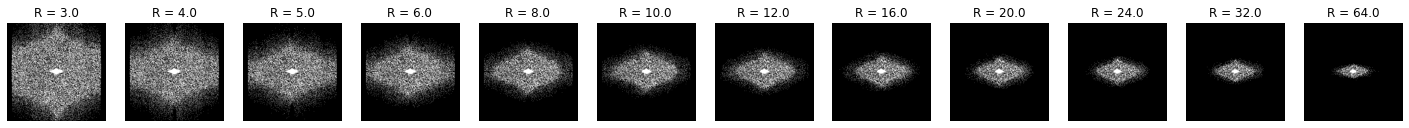

In [6]:
n = len(mask_list)

fig, axs = plt.subplots(1, n, squeeze = False)
fig.set_figheight(10)
fig.set_figwidth(25)
for m, ax, R in zip(mask_list, axs[0], R_list):
    
    uty._rotate_corners_mask(m, plot = True, ax = ax)
    ax.title.set_text('R = '+str(R))

In [7]:
path_to_save_mask_dict = os.path.join(
    'results_paper', 'masks', 'pkl', use_case+',pkl'
)
mask_dict = dict(zip(R_list, mask_list))

with open(path_to_save_mask_dict, 'wb') as f:
    pkl.dump(mask_dict, f)

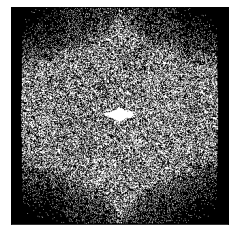

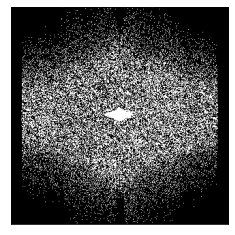

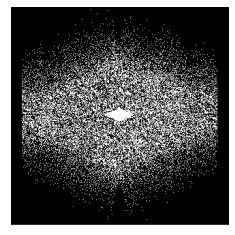

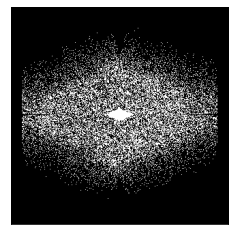

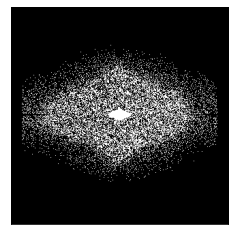

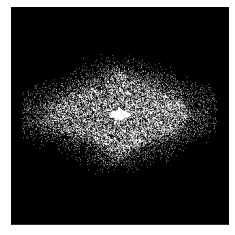

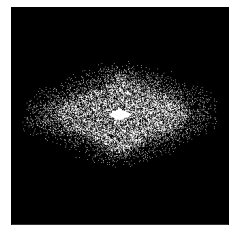

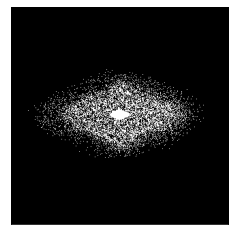

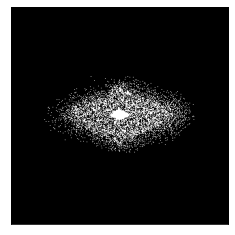

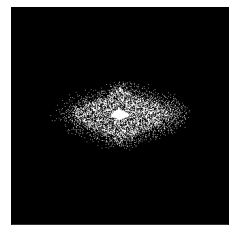

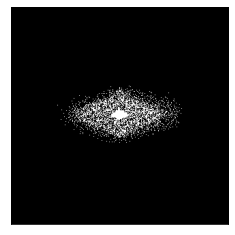

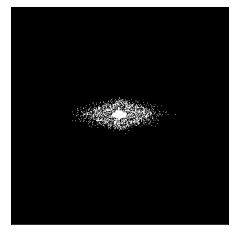

In [8]:
for m, R in zip(mask_list, R_list):
    
    m = uty._rotate_corners_mask(m, plot = False)
    
    fig, ax = plt.subplots()
    
    ax.imshow(m, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        os.path.join('results_paper', 'masks', 'fastMRI', f'mask_R_{R}_{use_case}.png'),bbox_inches='tight', 
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

### Priority Chart

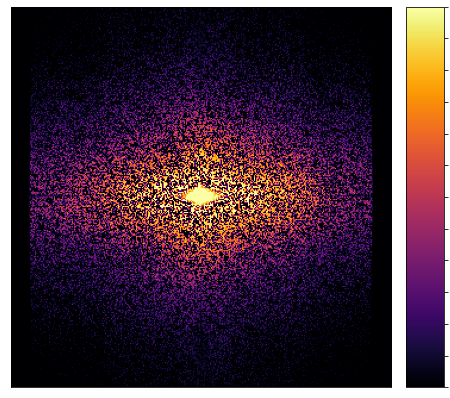

In [9]:
mask_list_rot = [uty._rotate_corners_mask(m) for m in mask_list]

priority_chart = np.sum(mask_list_rot, (0, 3))/len(mask_list_rot)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(7)
im = ax.imshow(priority_chart, cmap = 'inferno')
ax.set(yticks = [], xticks = [])

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.2)
cax.set(yticks=[], yticklabels=[])
# cax.set_ticks([])
# ax.set(title = 'PRIORITY CHART -- '+directory, )
cbar = plt.colorbar(im, cax=cax, )
ticks = np.append(np.arange(0, 1 , 1/(len(R_list))), 1.0)
ticks_labels = np.append([1.0], R_list)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks_labels)
cbar.set_ticklabels([])
plt.savefig(os.path.join('results_paper', f'priority_chart_{directory}.pdf'),bbox_inches='tight', pad_inches = 0)



plt.show();

In [10]:
t = np.repeat(np.arange(0, len(priority_chart), dtype = int), len(priority_chart))
data_list = np.array([t, np.ravel(priority_chart)])
index_list = ['t', 'priority']
data_for_csv = pd.DataFrame(index = np.arange(0, len(data_list[0])), data = np.array(data_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()
f_name = f'priority_{use_case}'
data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

In [11]:
start = 0.228
end = -2.93
num = np.arange(13)+1
# print(start - np.abs((end-start)/len(R_list)*(num-1)))
[(start - np.abs((end-start)/12*(i-1)), ) for i in num]

[(0.228,),
 (-0.03516666666666671,),
 (-0.29833333333333345,),
 (-0.5615000000000001,),
 (-0.8246666666666669,),
 (-1.0878333333333337,),
 (-1.3510000000000002,),
 (-1.614166666666667,),
 (-1.8773333333333337,),
 (-2.1405000000000003,),
 (-2.403666666666667,),
 (-2.666833333333334,),
 (-2.93,)]

### Modified Priority

In [12]:
mask_list_rot = [uty._rotate_corners_mask(m) for m in mask_list]
mask_list_R = [m*R_tmp for m, R_tmp in zip(mask_list_rot, R_list)]

def my_mult(m0, m1):
    
    # print(np.shape(m0), np.shape(m1))
    m = m0 + (m1 * (m0<0.5))
    return m

priority_R_chart = functools.reduce(my_mult, mask_list_R)

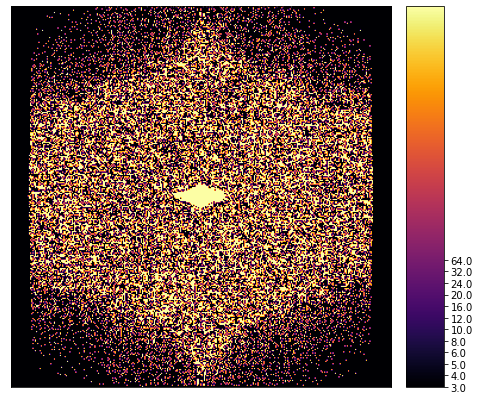

In [13]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(7)
im = ax.imshow(priority_R_chart, cmap = 'inferno')
ax.set(yticks = [], xticks = [])

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.2)
cax.set(yticks=[], yticklabels=[])
# cax.set_ticks([])
# ax.set(title = 'PRIORITY CHART -- '+directory, )
cbar = plt.colorbar(im, cax=cax, )
ticks = np.append(np.arange(0, 1 , 1/(len(R_list)-1)), 1.0)
ticks_labels = R_list
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks_labels)
plt.savefig(os.path.join('results_paper', f'priority_R_chart_{directory}.pdf'),bbox_inches='tight', pad_inches = 0)

plt.show();

In [14]:
score_dict = tscore_dict

## Score TRUE - PREDICTED comparison

Compare TRUE vs PREDICTED quality

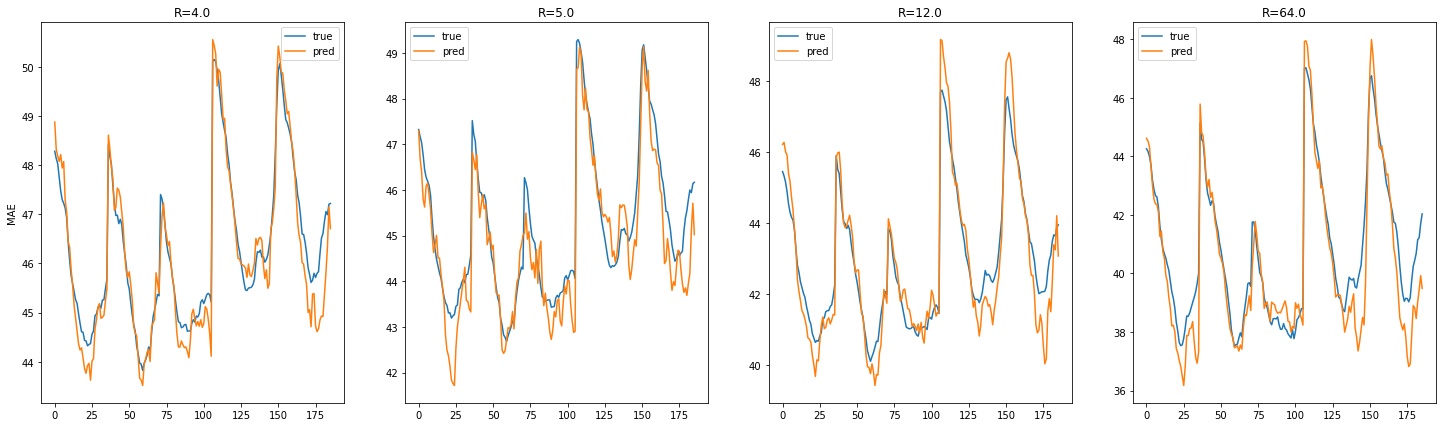

In [15]:
# R_to_visualize = np.sort(np.unique(np.array(R_list)[np.random.randint(0, len(R_list), 4)]))
R_to_visualize = [4.0, 5.0, 12.0, 64.0]
# R_to_visualize = R_list

metric_type_list = ['MAE']

fig, axs = plt.subplots(len(metric_type_list), len(R_to_visualize), sharey = False, squeeze = False)
fig.set_figheight(7*len(metric_type_list))
fig.set_figwidth(25)
        

for axx, metric_type in zip(
        axs,
        metric_type_list,
    ):
    for ax, R_tmp in zip(axx, R_to_visualize):
        
        g_tmp_str = ''
        ax.plot(score_dict[metric_type+'_true'][R_tmp],'')
        ax.plot(score_dict[metric_type+'_pred'][R_tmp],'')
        
        ax.legend(['true','pred'])
        ax.title.set_text('R='+str(R_tmp))

    axx[0].set_ylabel(metric_type)
    
plot_list = []
index_list = []

for metric_type in metric_type_list:
    for R_tmp in R_list:
        plot_list += [score_dict[metric_type+'_true'][R_tmp][36:151]]
        index_list += ['true_'+str(R_tmp)]
        
        plot_list += [score_dict[metric_type+'_pred'][R_tmp][36:151]]
        index_list += ['pred_'+str(R_tmp)]

f_name = f'volume_quality_pred_{use_case}'

# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

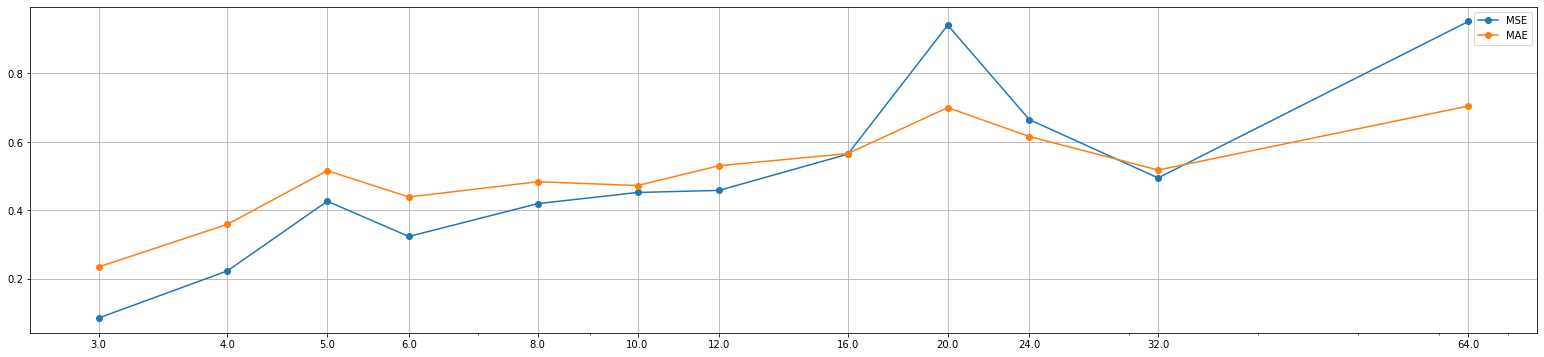

In [16]:
R_to_visualize = R_list

metric_type = 'MAE'

mse_pred = [np.mean((score_dict[metric_type+'_true'][R_tmp]-score_dict[metric_type+'_pred'][R_tmp])**2) for R_tmp in R_to_visualize]
mae_pred = [np.mean(np.abs(score_dict[metric_type+'_true'][R_tmp]-score_dict[metric_type+'_pred'][R_tmp])) for R_tmp in R_to_visualize]

fig, axs = plt.subplots(1, 1, squeeze = True)
fig.set_figheight(6)
fig.set_figwidth(27)

axs.plot(R_to_visualize, mse_pred, '-o', label = 'MSE');
axs.plot(R_to_visualize, mae_pred, '-o', label = 'MAE');

axs.set_xscale('log')
axs.set_xticks(R_to_visualize)
axs.set_xticklabels(R_to_visualize)
axs.legend()
axs.grid('on');

plot_list = [mse_pred, mae_pred, R_to_visualize]
index_list = ['MSE', 'MAE', 'R_plot']

f_name = f'quality_estimator_performance_{use_case}'

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

In [17]:
# R_list_to_delete = [20.0, 24.0, 64.0]

# score_dict_list = [tscore_dict, vscore_dict, xscore_dict]
# for score_dict in score_dict_list:
#     for k in score_dict.keys():
#         for R_tmp in R_list_to_delete:
#             score_dict[k].pop(R_tmp)
            

# for R_tmp in R_list_to_delete:
#     R_list.remove(R_tmp)

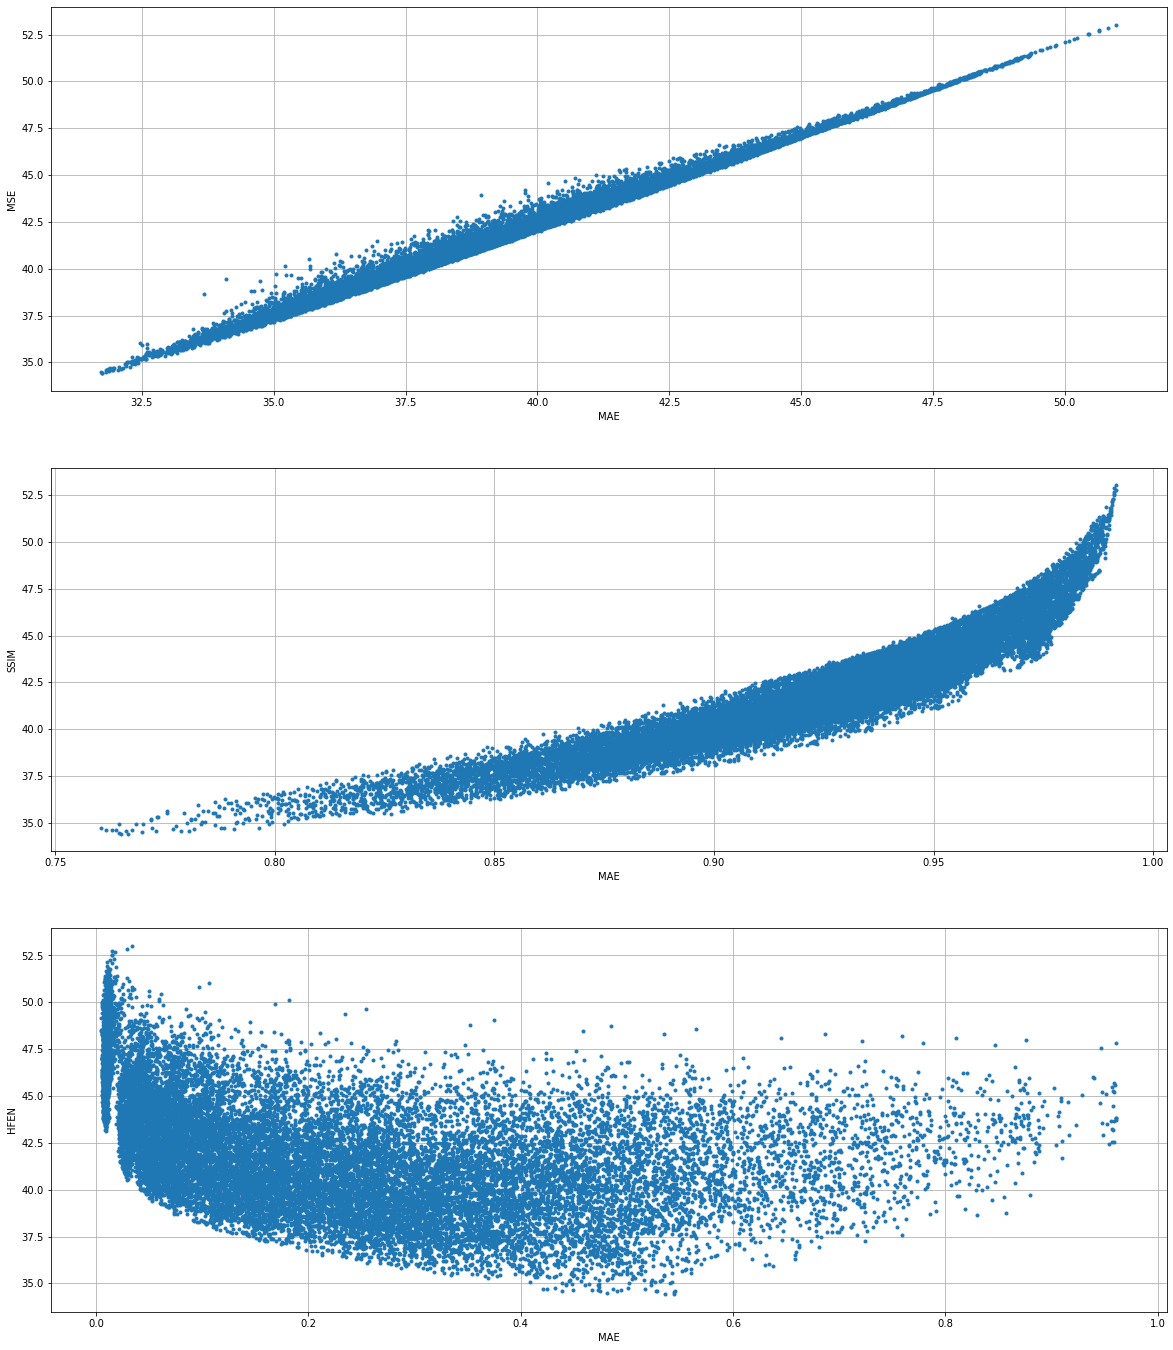

In [18]:
metric_type = ['MSE', 'MAE']

fig, axs = plt.subplots(3, 1)
fig.set_figheight(8*3)
fig.set_figwidth(20)


mae_true = np.array(list(xscore_dict['MAE_true'].values())).ravel()

mse_true = np.array(list(xscore_dict['MSE_true'].values())).ravel()

hfen_true = np.array(list(xscore_dict['HFEN_true'].values())).ravel()

ssim_true = np.array(list(xscore_dict['SSIM_true'].values())).ravel()


axs[0].plot(mse_true,mae_true,'.')
axs[1].plot(ssim_true,mae_true,'.')
axs[2].plot(hfen_true,mae_true,'.')

axs[0].set_ylabel('MSE')
axs[1].set_ylabel('SSIM')
axs[2].set_ylabel('HFEN')

for ax in axs:
    ax.grid('on')
    ax.set_xlabel('MAE')

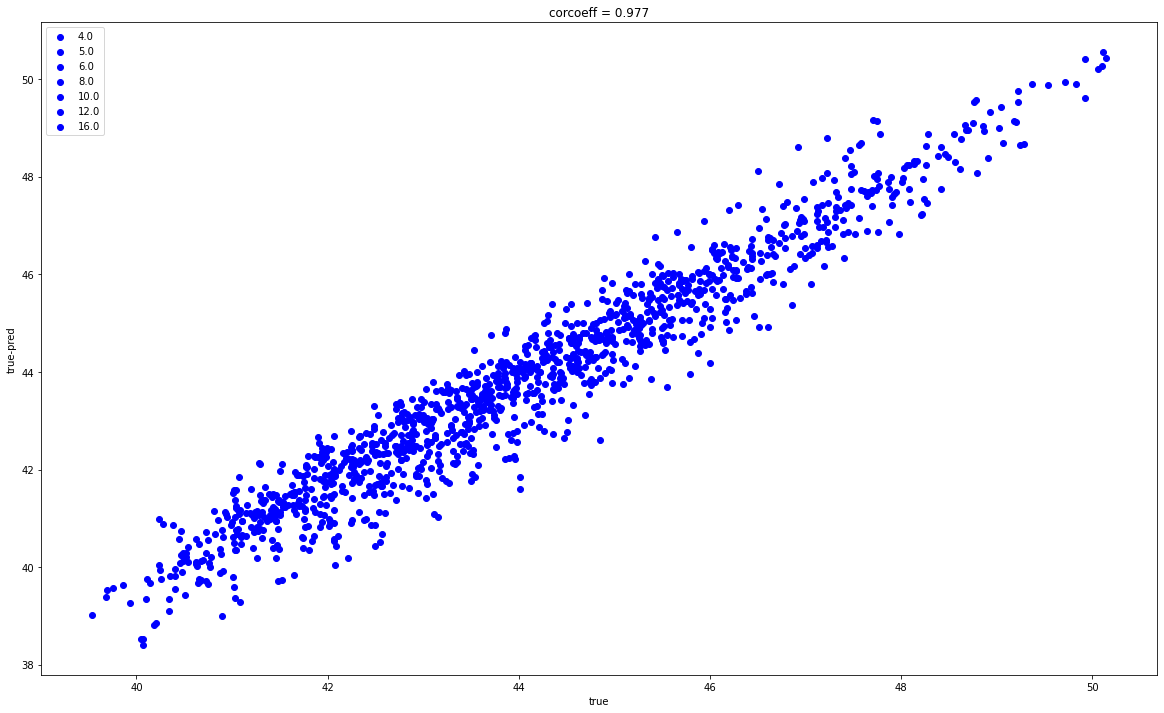

In [19]:
metric_type = ['MAE']

plot_list = []
index_list = []

R_to_visualize = [4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 16.0,]

fig, axs = plt.subplots(len(metric_type), 1, squeeze = False)
axs = axs[0]
fig.set_figheight(12)
fig.set_figwidth(20)
for ax, m in zip(axs, metric_type):
    
    score_true = [
            ax.scatter(tscore_dict[m+'_true'][R_tmp][-450:], tscore_dict[m+'_pred'][R_tmp][-450:], c = 'blue', label = R_tmp) 
            for R_tmp
            in R_to_visualize
        ]
    
    plot_list += [np.array([
            tscore_dict[m+'_true'][R_tmp][-450:]
            for R_tmp
            in R_to_visualize
        ]).reshape(-1)]
    
    index_list += ['MAE_true']
    
    plot_list += [np.array([
            tscore_dict[m+'_pred'][R_tmp][-450:]
            for R_tmp
            in R_to_visualize
        ]).reshape(-1)]
    
    index_list += ['MAE_pred']
    
    corrcoef = np.corrcoef(
            np.array([i for i in tscore_dict[m+'_true'].values()]).reshape(-1),
            np.array([i for i in tscore_dict[m+'_pred'].values()]).reshape(-1),
        )
    
    ax.title.set_text(f'corcoeff = {np.round(corrcoef[0][1], 3)}')
    ax.set_xlabel('true')
    ax.set_ylabel('true-pred');
    ax.legend()
    
f_name = f'MAE_pred_vs_true_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

### Corcoeff for different R

In [20]:
metric_type = ['MAE']

R_to_visualize = [4.0, 6.0, 10.0, 16.0]

print('\t\t', use_case)

for m in metric_type:
    
    for R_tmp in R_to_visualize:
        
        true_tmp, pred_tmp = tscore_dict[m+'_true'][R_tmp], tscore_dict[m+'_pred'][R_tmp]
        
        corrcoef = np.corrcoef(
                true_tmp, pred_tmp
            )
    
        print(f'{R_tmp}) corcoeff = {np.round(corrcoef[0][1], 3)}')

		 FastMRI-Unconstrained
4.0) corcoeff = 0.968
6.0) corcoeff = 0.96
10.0) corcoeff = 0.962
16.0) corcoeff = 0.97


## Visualization PSNR

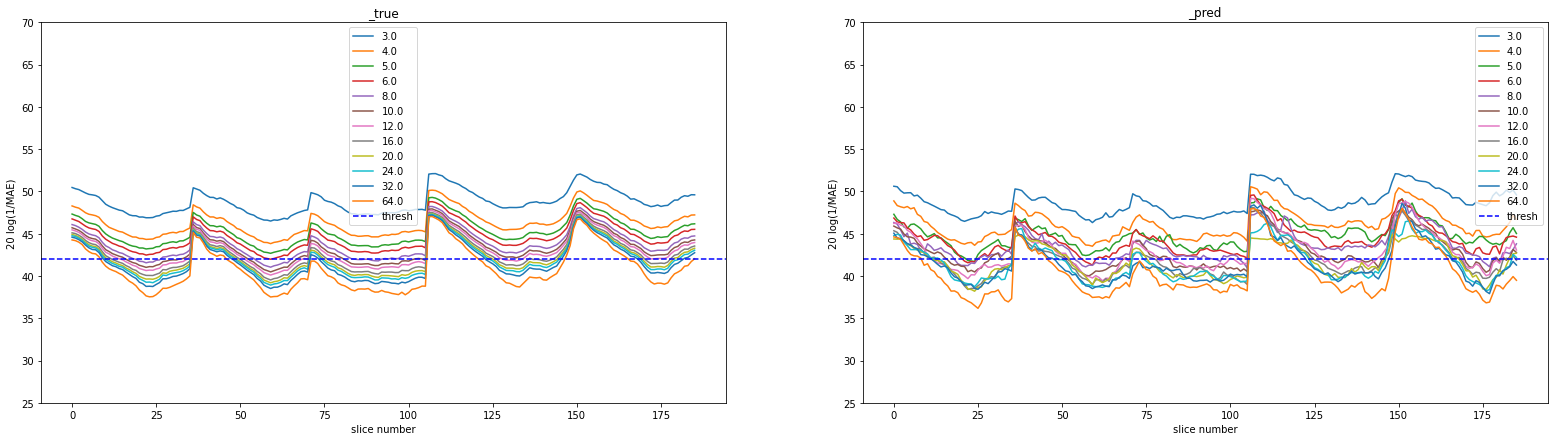

In [21]:
threshold_PSNR = 42 # PSNR = 10*log10(1/MSE) ---- MSE = 1/(10^(PSNR/10))
threshold_PSNR_MAE = 42

metric_type_list = ['MSE', 'MAE']
metric_type_list = ['MAE']

ylim = (25, 70)

fig, axss = plt.subplots(len(metric_type_list), 2, squeeze = False)
fig.set_figheight(7)
fig.set_figwidth(27)
for axs, metric_type, threshold in zip(axss, metric_type_list, [threshold_PSNR, threshold_PSNR_MAE]):
    
    for ax, data_type in zip(axs, ['_true', '_pred']):
        
        tscore_dict_tmp = tscore_dict[metric_type+data_type]
        
        [ax.plot(tscore_dict_tmp[R_tmp], label = str(R_tmp)) for R_tmp in R_list]

        ax.axhline(y = threshold, color = 'b', linestyle = '--', label = 'thresh')
        ax.legend()
        ax.set(xlabel = 'slice number', ylabel = '20 log(1/'+metric_type+')', ylim = ylim, title = data_type)

## MAURO REQUESTS

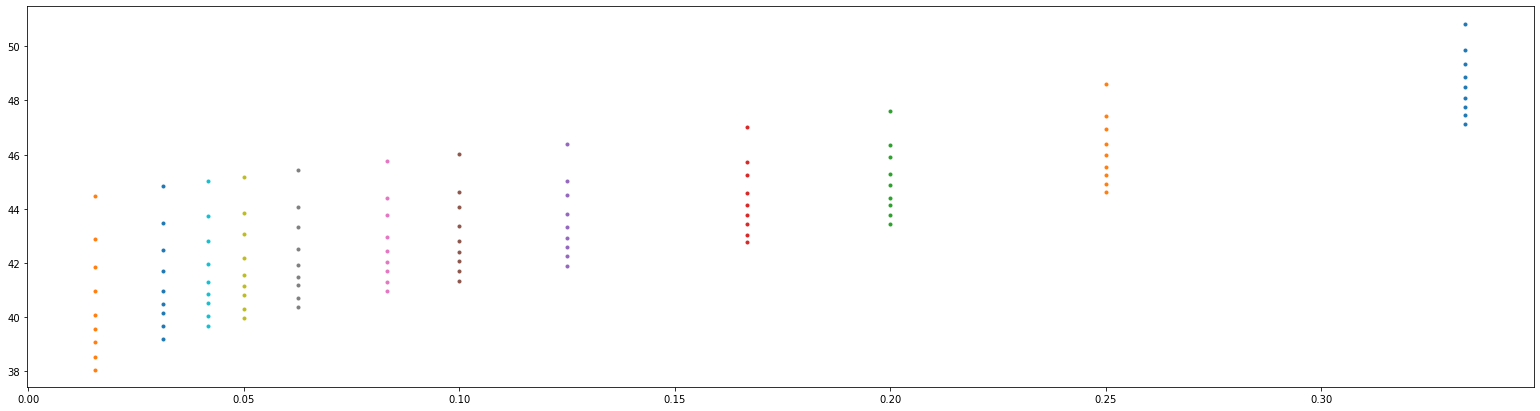

In [22]:
r_tmp =[
    [
        tscore_dict['MAE_true'][R_tmp][ind_tmp]
        for R_tmp
        in R_list
    ]
    for ind_tmp
    in range(len(tscore_dict['MAE_true'][4.0]))
]

a = np.linspace(0, 1, 11)
q = [
    np.quantile(i, a)[1:-1]
    for i
    in np.swapaxes(r_tmp, 0, 1)
]
np.shape(q)

fig, axs = plt.subplots(figsize = (27, 7))
[
    axs.plot(np.repeat(1/np.array(R_tmp), len(i)), i, '.')
    for i, R_tmp
    in zip(q, R_list)
];

# Final SPEED UP (oracle and not)

In [23]:
def final_speed_up(R_list, true, target, pred = None, geq = True, inf_quality_value = 50):
    
    if pred is None:
        pred = copy.deepcopy(true)
        
    R_list_sort = np.sort(R_list)[::-1]
    
    if geq == True:
        def compare(x, y):
            return x>=y
    else:
        def compare(x, y):
            return x<=y
    
    z = np.zeros(len(true[R_list[0]]))
    
    speed_up_vector = copy.deepcopy(z)
    metric_vector = copy.deepcopy(z)
    diff_vector = copy.deepcopy(z)
    
    
    for R_tmp in R_list_sort:
        true_tmp = true[R_tmp]
        pred_tmp = pred[R_tmp]
                
        condition = np.logical_and(compare(pred_tmp, target),
                                   speed_up_vector == 0,
                                  )
        speed_up_vector = np.where(condition,
                                   R_tmp,
                                   speed_up_vector,
                                  )
                
        metric_vector = np.where(condition,
                                 true_tmp,
                                 metric_vector,
                                )
        
        diff_vector = np.where(condition, 
                               true_tmp-pred_tmp,
                               diff_vector,
                              )
        
    speed_up_vector[speed_up_vector==0] = 1    
    metric_vector[metric_vector==0] = inf_quality_value
    diff_vector[diff_vector==0] = 0
    
    return (speed_up_vector, metric_vector, diff_vector)

In [24]:
def get_final_score(
        score_dict,
        R_list,
        thresh_list,
        data_type = ['_true', '_pred'],
        metric_type = ['MAE'],
        verbose = False,
        inf_quality_value = 50,
    ):
    
    speed_up_dict = {}
    metric_dict = {}
    diff_dict = {}

    for t_tmp in thresh_list:
        if verbose == True:
            print()
        for d, m in itertools.product(data_type, metric_type):

            true = score_dict[m+'_true']
            
            if d == '_true':
                pred = None
            else:
                pred = score_dict[m+'_pred']

            (speed_up, metric, diff) = final_speed_up(
                    R_list,
                    true,
                    t_tmp,
                    pred,
                    geq = True,
                    inf_quality_value = inf_quality_value,
                )

            speed_up_dict[m+d+'_T'+str(t_tmp)] = speed_up
            metric_dict[m+d+'_T'+str(t_tmp)] = metric
            diff_dict[m+d+'_T'+str(t_tmp)] = diff

            if verbose == True:
                print(m+d, t_tmp, np.round(np.mean(speed_up), 2), np.round(np.mean(metric), 2))

    return (speed_up_dict, metric_dict, diff_dict)

In [25]:
def extract_some_data_from_dict(dictionary, key):
    
    k_list_tmp = [k for k in list(speed_up_dict.keys()) if (key in k)]

    data = None
    for k_tmp in k_list_tmp:
        data_tmp = dictionary[k_tmp][np.newaxis]

        if data is None:
            data = data_tmp
        else:
            data = np.append(data, data_tmp, 0)
            
    return data

## merge train and validation together

In [26]:
score_dict = {}

keys = xscore_dict.keys()
for k in keys:
    score_dict[k] = {}
    for R_tmp in R_list:
        score_dict[k][R_tmp] = np.concatenate((xscore_dict[k][R_tmp], vscore_dict[k][R_tmp]), 0)

In [27]:
MAEdb_true = np.ravel(list((score_dict['MAE_true'].values())))
PSNR_true = np.ravel(list((score_dict['MSE_true'].values())))
SSIM_true = np.ravel(list((score_dict['SSIM_true'].values())))


thresh_MAEdb = np.arange(np.min(MAEdb_true), 50, 0.02)[1:]
thresh_MAEdb = np.arange(38, 49, 0.01)[1:]

# thresh_PSNR = np.arange(np.min(PSNR_true), 50, 0.001)[1:]
thresh_PSNR = np.arange(np.min(PSNR_true), 50, 0.001)[1:]

# thresh_SSIM = np.arange(np.min(SSIM_true), 1, 0.0001)[1:]
thresh_SSIM = np.arange(np.min(SSIM_true), 1, 0.0001)[1:]

def remove_None(L):
    return [x for x in L if x is not None]

thresh_MAEdb_for_PSNR = np.array([np.max(MAEdb_true[PSNR_true<t]) for t in thresh_PSNR])
thresh_MAEdb_for_SSIM = np.array([np.max(MAEdb_true[SSIM_true<t]) for t in thresh_SSIM])
thresh_MAEdb_for_MAEdb = np.array([np.max(MAEdb_true[MAEdb_true<t]) for t in thresh_MAEdb])

In [28]:
def my_unique(thresh_MAEdb_for_, thresh):
    _, ind_unique = np.unique(thresh_MAEdb_for_, return_index = True)

    thresh_MAEdb_for_ = np.array(thresh_MAEdb_for_)[ind_unique]
    thresh = np.array(thresh)[ind_unique]
    
    return thresh_MAEdb_for_, thresh

# thresh_MAEdb_for_PSNR, thresh_PSNR = my_unique(thresh_MAEdb_for_PSNR, thresh_PSNR)
# thresh_MAEdb_for_SSIM, thresh_SSIM = my_unique(thresh_MAEdb_for_SSIM, thresh_SSIM)
# thresh_MAEdb_for_MAEdb, thresh_MAEdb = my_unique(thresh_MAEdb_for_MAEdb, thresh_MAEdb)

In [29]:
# thresh_MAEdb_for_PSNR = np.sort(np.append(thresh_MAEdb_for_PSNR, [38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0]))
# thresh_MAEdb_for_SSIM = np.sort(np.append(thresh_MAEdb_for_SSIM, [38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0]))
# thresh_MAEdb_for_MAEdb = np.sort(np.append(thresh_MAEdb_for_MAEdb, [38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0]))

MSE
39.75690362549809
44.25890362550359
SSIM
0.9326780735812618
0.9661780735812581
MAE
43.999999999998806
46.99999999999821


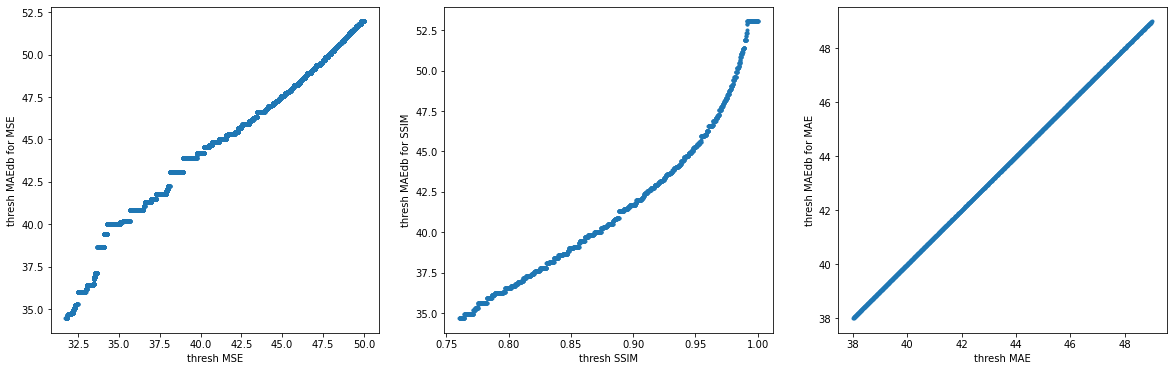

In [30]:
thresh_MAE_for_list = [thresh_MAEdb_for_PSNR, thresh_MAEdb_for_SSIM, thresh_MAEdb_for_MAEdb]
thresh_list = [thresh_PSNR, thresh_SSIM, thresh_MAEdb]
metric_type_list = ['MSE', 'SSIM', 'MAE']


fig, axs = plt.subplots(1, len(thresh_list))
fig.set_figwidth(20)
fig.set_figheight(6)


def find_nearest_arg(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

for ax, t_MAE, t, metric_type in zip(axs, thresh_MAE_for_list, thresh_list, metric_type_list):
    ax.plot(t, t_MAE, '.');
    ax.set(xlabel = 'thresh '+metric_type, ylabel = 'thresh MAEdb for '+metric_type)
    
    
    ind_tmp = find_nearest_arg(t_MAE, 44)
    print(metric_type)
    print(t[ind_tmp])
    
    ind_tmp = find_nearest_arg(t_MAE, 47)
    
    print(t[ind_tmp])
    

In [31]:
def expand_score_dictand_R_list(score_dict, R_list, metric_type_list = ['MAE', 'MSE', 'SSIM']):
    
    for metric_type in metric_type_list:
    
        len_tmp = len(score_dict[metric_type+'_true'][list(score_dict[metric_type+'_true'].keys())[0]])
    
        if metric_type == 'SSIM':
            R_1_performance = 1
        elif metric_type == 'MAE':
            R_1_performance = 60
            score_dict[metric_type+'_pred'].update({1.0: np.ones(len_tmp)*R_1_performance})
        elif metric_type == 'MSE':
            R_1_performance = 60        

        score_dict[metric_type+'_true'].update({1.0: np.ones(len_tmp)*R_1_performance})

    R_list = [1.0] + R_list
    
    return score_dict, R_list

score_dict_expanded, R_list_expanded = expand_score_dictand_R_list(score_dict, R_list)

In [32]:
score_dict = tscore_dict
score_dict, R_list_expanded = expand_score_dictand_R_list(score_dict, R_list)

In [33]:
inf_quality_value = None
tfinal_score_MAEdb = {}
tfinal_score_MAEdb = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_MAEdb_for_MAEdb,
            data_type = ['_true', '_pred'],
            metric_type = ['MAE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_MAEdb, tmetric_dict_MAEdb, tdiff_dict_MAEdb) = tfinal_score_MAEdb[1]

In [34]:
inf_quality_value = None
tfinal_score_PSNR = {}
tfinal_score_PSNR = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_MAEdb_for_PSNR,
            data_type = ['_true', '_pred'],
            metric_type = ['MAE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_PSNR, tmetric_dict_PSNR, tdiff_dict_PSNR) = tfinal_score_PSNR[1]

In [35]:
inf_quality_value = None
tfinal_score_SSIM = {}
tfinal_score_SSIM = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_MAEdb_for_SSIM,
            data_type = ['_true', '_pred'],
            metric_type = ['MAE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_SSIM, tmetric_dict_SSIM, tdiff_dict_SSIM) = tfinal_score_SSIM[1]

In [36]:
inf_quality_value = None
tfinal_score_PSNR_oracle = {}
tfinal_score_PSNR_oracle = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_PSNR,
            data_type = ['_true'],
            metric_type = ['MSE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_PSNR_oracle, tmetric_dict_PSNR_oracle, tdiff_dict_PSNR_oracle) = tfinal_score_PSNR_oracle[1]

inf_quality_value = None
tfinal_score_SSIM_oracle = {}
tfinal_score_SSIM_oracle = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_SSIM,
            data_type = ['_true'],
            metric_type = ['SSIM'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_SSIM_oracle, tmetric_dict_SSIM_oracle, tdiff_dict_SSIM_oracle) = tfinal_score_SSIM_oracle[1]

In [37]:
metric_type_list = ['SSIM', 'MSE', 'MAE']
data_type_list = ['true', 'pred']

tspeed_up_dict_list = [tspeed_up_dict_SSIM, tspeed_up_dict_PSNR, tspeed_up_dict_MAEdb]
tspeed_up_dict_oracle_list = [tspeed_up_dict_SSIM_oracle, tspeed_up_dict_PSNR_oracle, tspeed_up_dict_MAEdb]

results_based_on_MAEdb = {}

thresh_MAEdb_list = [thresh_MAEdb_for_SSIM, thresh_MAEdb_for_PSNR, thresh_MAEdb_for_MAEdb]
thresh_list = [thresh_SSIM, thresh_PSNR, thresh_MAEdb]

for data_type in data_type_list:

    for tspeed_up_dict_tmp, tspeed_up_dict_oracle_tmp, metric_type, thresh_MAE_list_tmp, thresh_list_tmp in zip(tspeed_up_dict_list, tspeed_up_dict_oracle_list, metric_type_list, thresh_MAEdb_list, thresh_list):
        
        results_based_on_MAEdb['thresh_MAE_for_'+metric_type] = thresh_MAE_list_tmp
        results_based_on_MAEdb['thresh_'+metric_type] = thresh_list_tmp
        
        for t_MAE, t in zip(thresh_MAE_list_tmp, thresh_list_tmp):

            k_MAE_tmp = metric_type+'_'+data_type+'_TMAE'+str(t_MAE)
            k_tmp = metric_type+'_'+data_type+'_T'+str(t)
            
            tspeed_up_tmp = tspeed_up_dict_tmp['MAE_'+data_type+'_T'+str(t_MAE)]
            
            if data_type == 'true' and metric_type != 'MAE':
                tspeed_up_tmp = tspeed_up_dict_oracle_tmp[metric_type+'_'+data_type+'_T'+str(t)]
            
            results_based_on_MAEdb['speed_up_'+k_MAE_tmp] = tspeed_up_tmp
            results_based_on_MAEdb['speed_up_'+k_tmp] = tspeed_up_tmp
            
            results_based_on_MAEdb[k_MAE_tmp] = np.empty(len(tspeed_up_tmp))
            results_based_on_MAEdb[k_tmp] = np.empty(len(tspeed_up_tmp))

            for i, s in enumerate(tspeed_up_tmp):

                if s in R_list:
                    results_based_on_MAEdb[k_MAE_tmp][i] = tscore_dict[metric_type+'_true'][s][i]
                    results_based_on_MAEdb[k_tmp][i] = tscore_dict[metric_type+'_true'][s][i]
                elif metric_type == 'MSE' or metric_type == 'MAE':
                    results_based_on_MAEdb[k_MAE_tmp][i] = 60
                    results_based_on_MAEdb[k_tmp][i] = 60
                elif metric_type == 'SSIM':
                    results_based_on_MAEdb[k_MAE_tmp][i] = 1
                    results_based_on_MAEdb[k_tmp][i] = 1

## Re-define quality target

FastMRI-Unconstrained




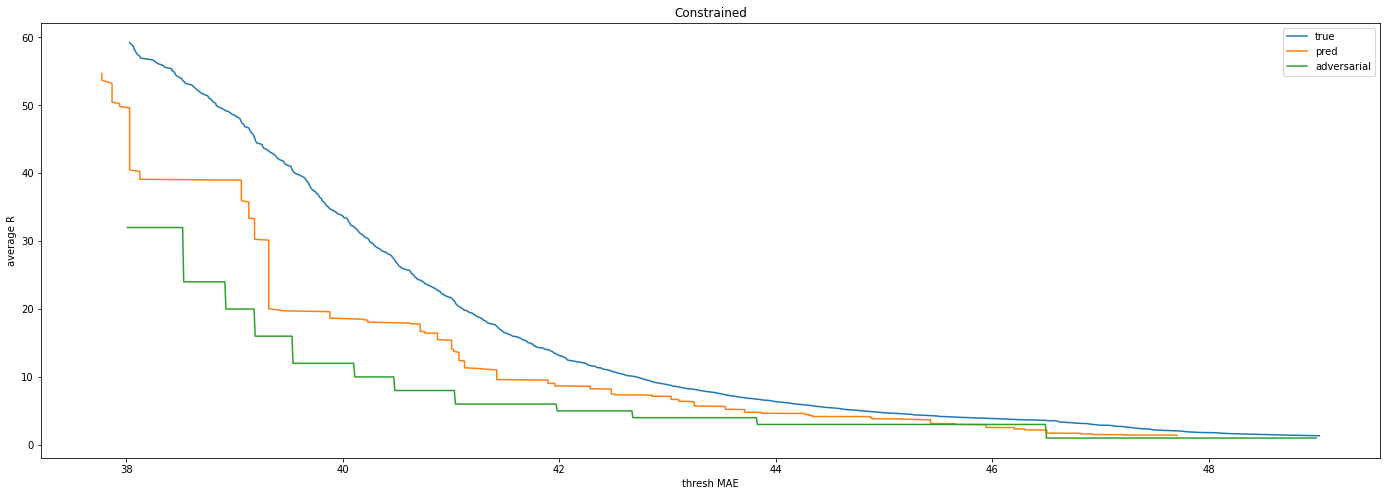

In [38]:
score_dict = tscore_dict

metric_type_list = ['MSE', 'SSIM', 'MAE']

metric_type_list = ['MAE']

ylim = [None, None]
xlim = (30, 47)

fig, axs = plt.subplots(1, len(metric_type_list), squeeze = False)
fig.set_figwidth(24)
fig.set_figheight(8)

axs = axs[0]

data_type_list = ['true', 'pred']

print(use_case)
print()
print()


plot_list = []
index = []
to_table = {}

for metric_type, ax in zip(metric_type_list, axs):
    
    x_plot = results_based_on_MAEdb['thresh_'+metric_type]
    
    for data_type in data_type_list:
        
        metric_min_list = np.array([np.min(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t_tmp)]) for t_tmp in x_plot])
        
        y_plot = [1/(np.mean(1/(results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t_tmp)]))) for t_tmp in x_plot]
        
        to_table[data_type] = [y_plot[np.argmin(np.abs(metric_min_list-i))] for i in np.arange(38, 47)]
        
        ax.plot(metric_min_list, y_plot, label = data_type)
        
        plot_list += [y_plot]
        index += ['y_'+data_type]
        
        plot_list += [metric_min_list]
        index += ['x_'+data_type]
        
        
        results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type] = metric_min_list
        
        for t_tmp, t_new in zip(x_plot, metric_min_list):
            results_based_on_MAEdb[metric_type+'_'+data_type+'_Tnew'+str(t_new)] = results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t_tmp)]
            results_based_on_MAEdb['speed_up'+'_'+metric_type+'_'+data_type+'_Tnew'+str(t_new)] = results_based_on_MAEdb['speed_up'+'_'+metric_type+'_'+data_type+'_T'+str(t_tmp)]
        
    R_adversarial = [
        R_list_expanded[::-1][np.argmax(
            [
                np.sum(score_dict[metric_type+'_true'][R_tmp]>t_tmp)
                for R_tmp in R_list_expanded[::-1]
            ]
        )]
        for t_tmp in x_plot
    ]
    
    to_table['adversarial'] = [R_adversarial[np.argmin(np.abs(x_plot-i))] for i in np.arange(38, 47)]
    to_table['index'] = np.arange(38, 47)
    ax.plot(x_plot, R_adversarial, label = 'adversarial')
    
    plot_list += [R_adversarial]
    index += ['y_adversarial']

    plot_list += [x_plot]
    index += ['x_adversarial']
    
    ax.legend()
    if metric_type == 'SSIM':
        xlim = (None, 1)
    else:
        xlim = (None, None)
    ax.set(title = 'Constrained', xlabel = 'thresh '+metric_type, ylabel = 'average R', xlim = xlim, ylim = ylim)

with open(os.path.join('results_paper', 'table_'+use_case+'.pkl'), 'wb') as f:
    pkl.dump(to_table, f)

f_name = f'R_vs_quality_target_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

# Plot speed up factors for every slice (incremental acquisition), with and without oracle

In [39]:
threshold_MAEdb = 43
threshold_PSNR = 44
threshold_SSIM = 0.95

## Redefine threshold

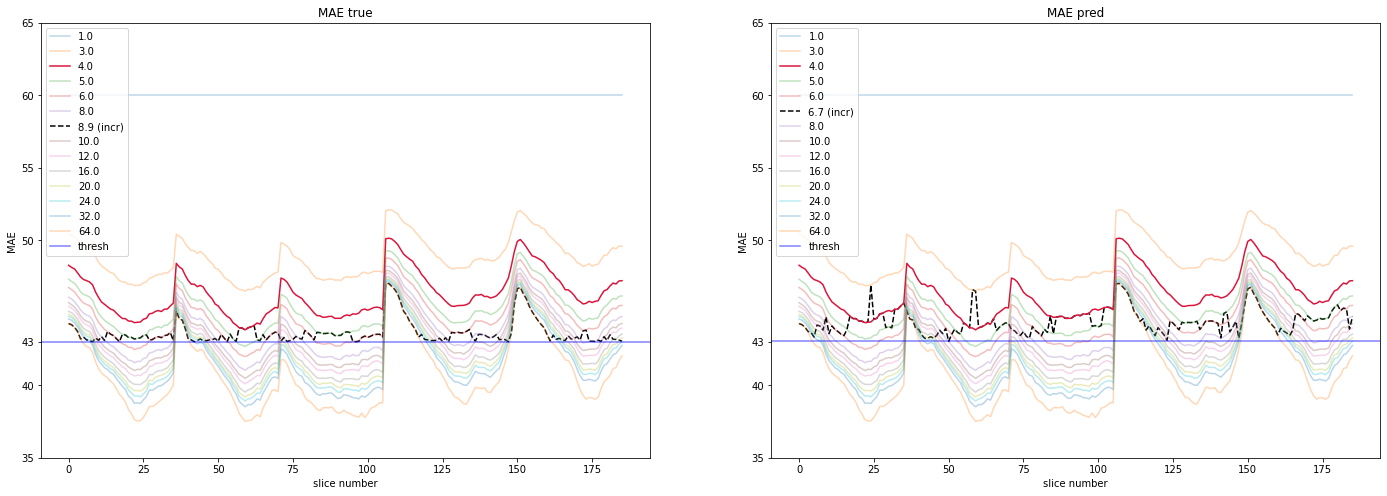

In [40]:
metric_type_list = ['MAE']

percentile = 0

data_type_list = ['true', 'pred']

threshold_list = [threshold_MAEdb, threshold_PSNR, threshold_SSIM]

fig, axss = plt.subplots(len(metric_type_list), len(data_type_list), squeeze = False)

fig.set_figheight(8*len(metric_type_list))
fig.set_figwidth(12*len(data_type_list))

for axs, metric_type, threshold in zip(axss, metric_type_list, threshold_list):
    
    thresh_MAE_for_tmp = results_based_on_MAEdb['thresh_MAE_for_'+metric_type]
    thresh_tmp = results_based_on_MAEdb['thresh_'+metric_type]
    
    t_MAE = thresh_MAE_for_tmp[np.argmin(np.abs(thresh_MAE_for_tmp-threshold))]
    t = thresh_tmp[np.argmin(np.abs(thresh_tmp-threshold))]
    
    for ax, data_type in zip(axs, data_type_list):
        
        if data_type == 'pred':
            new_thresh_tmp = results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type]
            new_t = new_thresh_tmp[np.argmin(np.abs(new_thresh_tmp-t))]
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_Tnew'+str(new_t)]
            
        elif data_type == 'true':
            new_t = np.percentile(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)], percentile)
        
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t)]

        R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)
        
                
        R_adversarial = R_list_expanded[::-1][np.argmax([
            np.sum(score_dict[metric_type+'_true'][R_tmp]>new_t)
            for R_tmp
            in R_list_expanded[::-1]
        ])]
        
        if data_type == 'pred':
            ax.plot(results_based_on_MAEdb[metric_type+'_'+data_type+'_Tnew'+str(new_t)],
                    'k--',
                    label = str(np.round(R_incremental, 1))+' (incr)',
                   ) 
            
        elif data_type == 'true':
            ax.plot(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)],
                    'k--',
                    label = str(np.round(R_incremental, 1))+' (incr)',
                   ) 
            
        
        def pick_alpha(R_adversarial, R_tmp, alpha = 0.3):
            if R_adversarial == R_tmp:
                return 1
            else:
                return alpha
            
        def pick_color(R_adversarial, R_tmp, color = 'crimson'):
            if R_adversarial == R_tmp:
                return color
            else:
                return ''
        
        [ax.plot(score_dict[metric_type+'_true'][R_tmp],
                 pick_color(R_adversarial, R_tmp),
                 alpha = pick_alpha(R_adversarial, R_tmp),
                 label = str(R_tmp),
                ) for R_tmp in R_list_expanded]
            
        ax.axhline(new_t,
                   color = 'b',
                   linestyle='-', 
                   alpha = 0.5,
                   label = f'thresh',
                  )
        
        handles, labels = ax.get_legend_handles_labels()
        
        order = np.argsort([R_incremental]+R_list_expanded+[1000])
                
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
        
        yticks = list(ax.get_yticks())
        
        yticks[np.argmin(np.abs(yticks-t))] = t
        
        ax.set(xlabel = 'slice number',
               ylabel = metric_type, 
               title = metric_type+' '+data_type,
               yticks = yticks,
              )
        
# fig.savefig(os.path.join('results_paper', f'Q_vs_slice_thresh_{np.round(threshold_MAEdb, 0)}_{use_case}.pdf'),bbox_inches='tight');

Q_vs_slice-target_43_FastMRI-Unconstrained


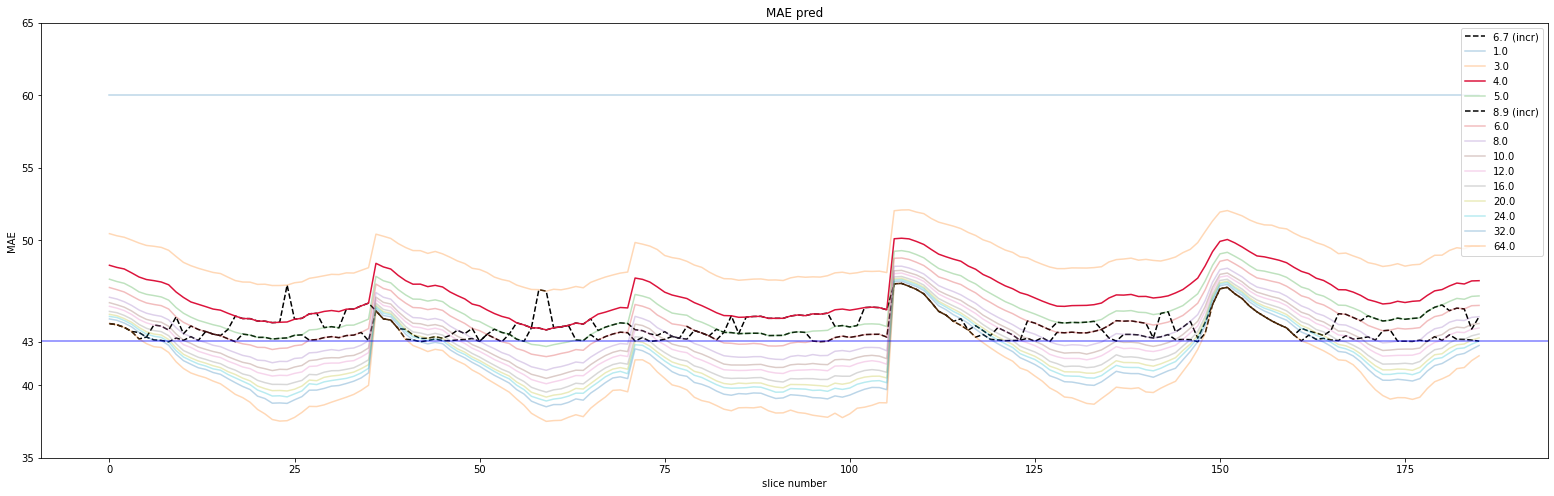

In [41]:
metric_type_list = ['MAE']

percentile = 0

data_type_list = ['true', 'pred']

threshold_list = [threshold_MAEdb]

fig, axss = plt.subplots(1, 1, squeeze = False)

fig.set_figheight(8*len(metric_type_list))
fig.set_figwidth(27)

plot_list = []
index_list = []

for axs, metric_type, threshold in zip(axss, metric_type_list, threshold_list):
    
    thresh_MAE_for_tmp = results_based_on_MAEdb['thresh_MAE_for_'+metric_type]
    thresh_tmp = results_based_on_MAEdb['thresh_'+metric_type]
    
    t_MAE = thresh_MAE_for_tmp[np.argmin(np.abs(thresh_MAE_for_tmp-threshold))]
    t = thresh_tmp[np.argmin(np.abs(thresh_tmp-threshold))]
    
    for ax in axs:
    
        color_list = ['k--', 'b--']
    
        for data_type, color in zip(data_type_list, color_list):

            if data_type == 'pred':
                new_thresh_tmp = results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type]
                new_t = new_thresh_tmp[np.argmin(np.abs(new_thresh_tmp-t))]
                speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_Tnew'+str(new_t)]

            elif data_type == 'true':
                new_t = np.percentile(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)], percentile)

                speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t)]

            R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)


            R_adversarial = R_list_expanded[::-1][np.argmax([
                np.sum(score_dict[metric_type+'_true'][R_tmp]>new_t)
                for R_tmp
                in R_list_expanded[::-1]
            ])]

            if data_type == 'pred':
                y_plot = results_based_on_MAEdb[metric_type+'_'+data_type+'_Tnew'+str(new_t)]

            elif data_type == 'true':
                y_plot = results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)]
            
            ax.plot(y_plot,
                    'k--',
                    label = str(np.round(R_incremental, 1))+' (incr)',
                   )
            
            plot_list += [y_plot]
            index_list += ['y_'+data_type]

            def pick_alpha(R_adversarial, R_tmp, alpha = 0.3):
                if R_adversarial == R_tmp:
                    return 1
                else:
                    return alpha

            def pick_color(R_adversarial, R_tmp, color = 'crimson'):
                if R_adversarial == R_tmp:
                    return color
                else:
                    return ''

        [ax.plot(score_dict[metric_type+'_true'][R_tmp],
                 pick_color(R_adversarial, R_tmp),
                 alpha = pick_alpha(R_adversarial, R_tmp),
                 label = str(R_tmp),
                ) for R_tmp in R_list_expanded]

        for R_tmp in R_list_expanded:
            plot_list += [score_dict[metric_type+'_true'][R_tmp]]
            index_list += [str(R_tmp)]
            
        ax.axhline(new_t,
                   color = 'b',
                   linestyle='-', 
                   alpha = 0.5,
                   label = f'thresh',
                  )
        
        plot_list += [[threshold_MAEdb]*len(score_dict[metric_type+'_true'][R_tmp])]
        index_list += ['thresh']

        handles, labels = ax.get_legend_handles_labels()

        order = np.argsort([R_incremental]+R_list_expanded+[1000])

        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

        yticks = list(ax.get_yticks())

        yticks[np.argmin(np.abs(yticks-t))] = t

        ax.set(xlabel = 'slice number',
               ylabel = metric_type, 
               title = metric_type+' '+data_type,
               yticks = yticks,
              )
        
f_name = f'Q_vs_slice-target_{threshold_MAEdb}_{use_case}'
print(f_name)
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)
        
fig.savefig(os.path.join('results_paper', f'Q_vs_slice_unified_thresh_{np.round(threshold_MAEdb, 0)}_{use_case}.pdf'),bbox_inches='tight');

dict_Q_tmp = dict(zip(index_list, plot_list))

In [42]:
threshold_MAEdb = threshold_MAEdb
threshold_PSNR = threshold_PSNR
threshold_SSIM = threshold_SSIM

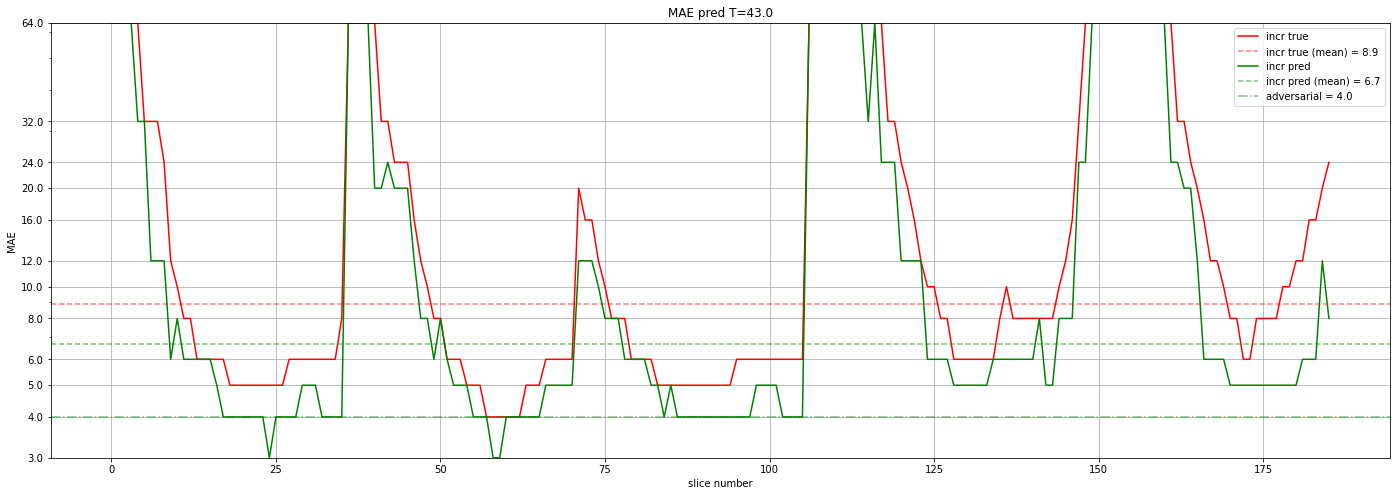

In [43]:
# metric_type_list = ['MAE', 'MSE', 'SSIM']
metric_type_list = ['MAE']

data_type_list = ['true', 'pred']

threshold_list = [threshold_MAEdb, threshold_PSNR, threshold_SSIM]

fig, axs = plt.subplots(len(metric_type_list), 1, squeeze = False)

fig.set_figheight(8*len(metric_type_list))
fig.set_figwidth(12*len(data_type_list))

plot_list = []
index_list = []

for ax, metric_type, threshold in zip(axs, metric_type_list, threshold_list):
    
    thresh_tmp = results_based_on_MAEdb['thresh_'+metric_type]
    thresh_new_tmp = np.array(results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type])
    
    t = thresh_tmp[np.argmin(np.abs(thresh_tmp-threshold))]
    t_new = thresh_new_tmp[np.argmin(np.abs(thresh_new_tmp-threshold))]
    
    for data_type, color in zip(data_type_list, ['r', 'g']):
        
        if data_type == 'true':
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t)]
            
        elif data_type == 'pred':
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_Tnew'+str(t_new)]
        
        R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)
        
        R_adversarial = R_list_expanded[::-1][np.argmax([
            np.sum(score_dict[metric_type+'_true'][R_tmp]>t)
            for R_tmp
            in R_list_expanded[::-1]
        ])]
        
        ax[0].plot(speed_up_tmp,
                color,
                label = 'incr '+data_type,
               )
        
        plot_list += [speed_up_tmp]
        index_list += [data_type]
            
        ax[0].axhline(R_incremental,
                   color = color,
                   linestyle='--', 
                   alpha = 0.5,
                   label = f'incr '+data_type+' (mean) = '+str(np.round(R_incremental, 1)),
                  )
        
        plot_list += [[R_incremental]*len(speed_up_tmp)]
        index_list += [data_type+'_mean']
        
    ax[0].axhline(R_adversarial,
               color = color,
               linestyle='-.', 
               alpha = 0.5,
               label = f'adversarial = '+str(np.round(R_adversarial, 1)),
              )
    plot_list += [[R_adversarial]*len(speed_up_tmp)]
    index_list += ['adversarial']
        

    ax[0].set()
    ax[0].legend()

    ax[0].set(xlabel = 'slice number',
              ylabel = metric_type, 
              title = metric_type+' '+data_type+' T='+str(np.round(t, 1)),
              yscale = 'log',
              yticks = R_list,
              yticklabels = R_list,
              ylim = (R_list[0], R_list[-1]),
          )
    ax[0].grid()

f_name = f'R_vs_slice-target_{threshold_MAEdb}_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

dict_R_tmp = dict(zip(index_list, plot_list))

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

In [61]:
index_list_tmp = [5, 15 ,25, 35, ]

# index_list_tmp = [40, 60, 80, 100, 120, 140, 160, 180]

# index_list_tmp = [120, 130 ,140]

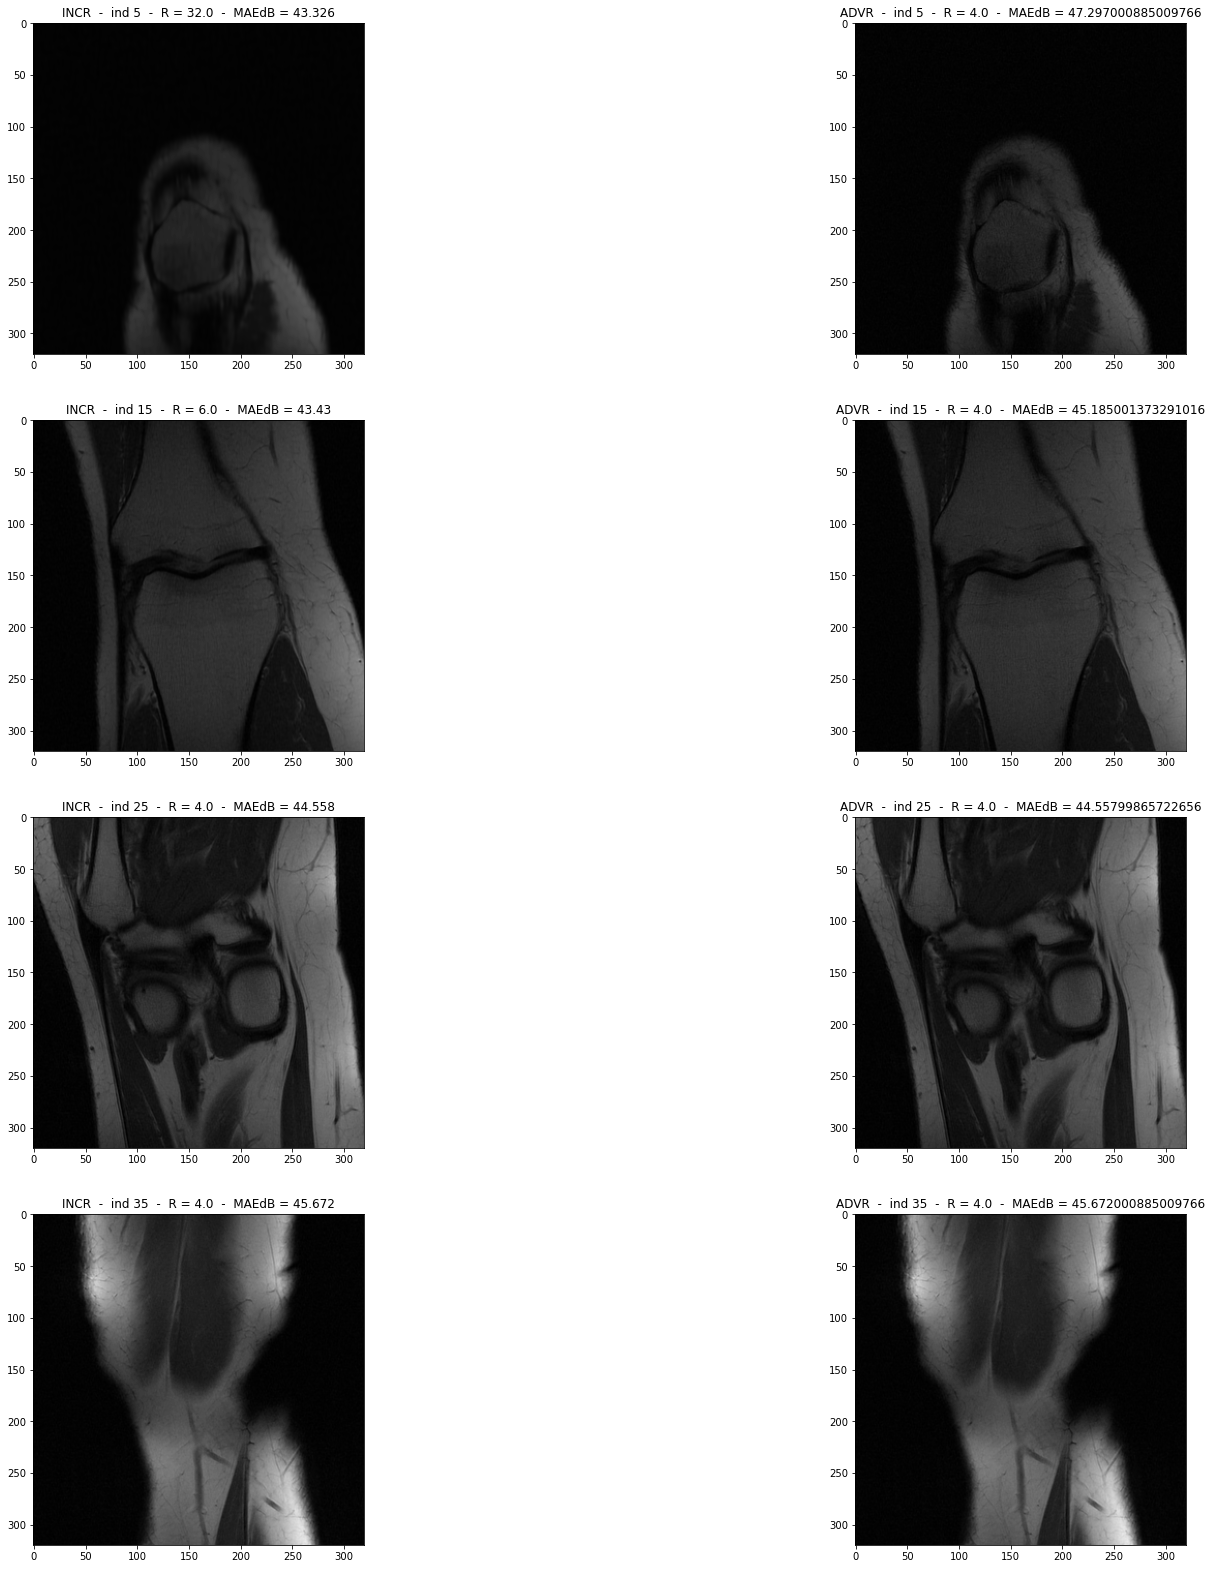

In [45]:
fig, axs = plt.subplots(len(index_list_tmp), 2, )
fig.set_figwidth(27)
fig.set_figheight(7*4)

R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    ax[0].imshow(timage_dict[R_tmp][ind_tmp, ..., 0], cmap = 'gray', vmin = 0, vmax = 1)
    ax[0].set(title = f'INCR  -  ind {ind_tmp}  -  R = {R_tmp}  -  MAEdB = {np.round(Q_tmp, 3)}')

R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    ax[1].imshow(timage_dict[R_tmp][ind_tmp, ..., 0], cmap = 'gray', vmin = 0, vmax = 1)
    ax[1].set(title = f'ADVR  -  ind {ind_tmp}  -  R = {R_tmp}  -  MAEdB = {np.round(Q_tmp, 3)}')
    

# path_tmp = os.path.join(
#         'results_paper',
#         'anatomical_volumes',
#         f'slice-ind_{ind}-R_{R}-{use_case}.pdf',
#     )

# plt.savefig(path_tmp, bbox_inches='tight', pad_inches = 0, transparent = True )


In [46]:
max_contrast = True

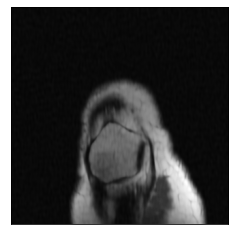

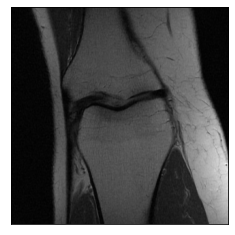

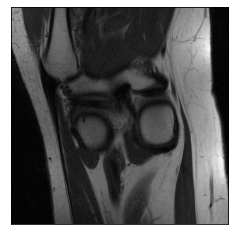

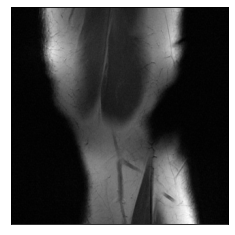

In [47]:
# fig, axs = plt.subplots(len(index_list_tmp), 2, )
# fig.set_figwidth(27)
# fig.set_figheight(7*4)

R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    # plt.imshow(timage_dict[R_tmp][ind_tmp, ..., 0], cmap = 'gray', vmin = 0, vmax = 1)
    # ax[0].set(title = f'INCR  -  ind {ind_tmp}  -  R = {R_tmp}  -  MAEdB = {np.round(Q_tmp, 3)}')
    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'more', 
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_reb.pdf',
        )

    # plt.axis('off')
    # plt.savefig(path_tmp, bbox_inches='tight', pad_inches = 0, transparent = True)

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    
    if max_contrast:
        im_tmp = im_tmp / np.max(im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

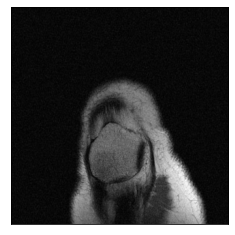

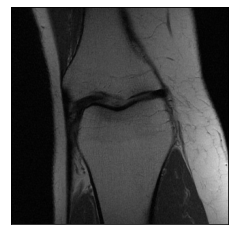

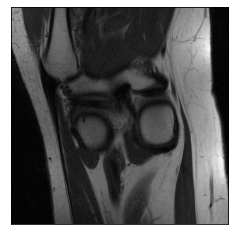

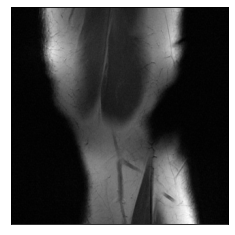

In [48]:
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'more', 
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_reb.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    
    if max_contrast:
        im_tmp = im_tmp / np.max(im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

## Diff w.r.t. ground truth

In [49]:
(_, _, tdata) = uty.load_dataset(dataset = 'PD')

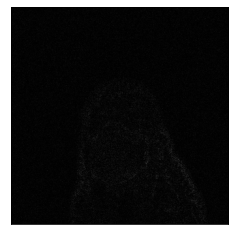

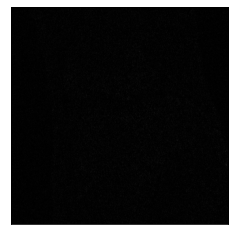

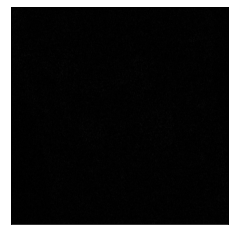

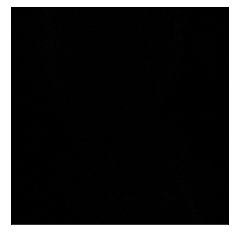

In [50]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()
    

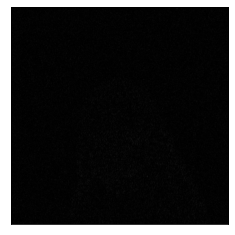

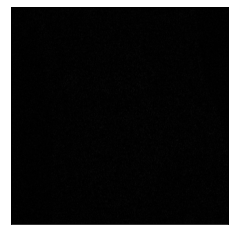

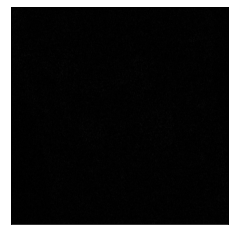

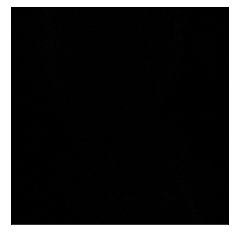

In [51]:
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

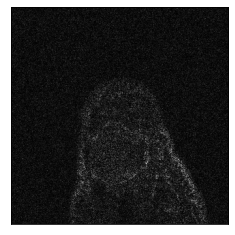

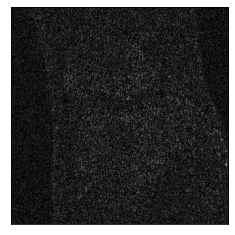

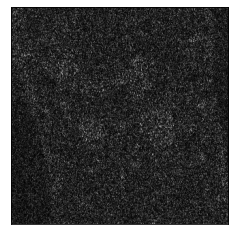

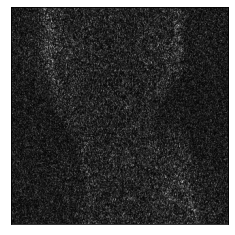

In [52]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
        im_tmp = np.abs(im_ref - im_tmp)
        
        im_tmp = im_tmp / np.max(im_tmp)
    
    
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()
    

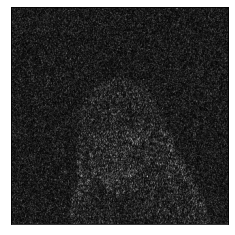

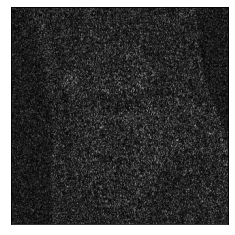

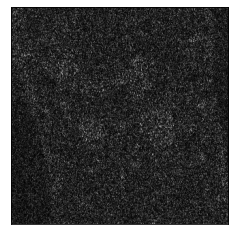

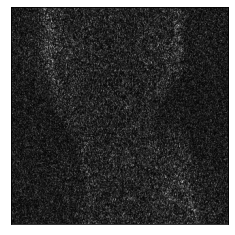

In [53]:
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    im_tmp = im_tmp / np.max(im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

## New results presentation

In [54]:
metric_type_list = ['SSIM', 'MSE', 'MAE']
data_type_list = ['true', 'pred']

tspeed_up_dict_list = [tspeed_up_dict_SSIM, tspeed_up_dict_PSNR, tspeed_up_dict_MAEdb]
tspeed_up_dict_oracle_list = [tspeed_up_dict_SSIM_oracle, tspeed_up_dict_PSNR_oracle, tspeed_up_dict_MAEdb]

results_based_on_MAEdb_2 = {}

thresh_MAEdb_list = [thresh_MAEdb_for_SSIM, thresh_MAEdb_for_PSNR, thresh_MAEdb_for_MAEdb]
thresh_list = [thresh_SSIM, thresh_PSNR, thresh_MAEdb]

for data_type in data_type_list:

    for tspeed_up_dict_tmp, tspeed_up_dict_oracle_tmp, metric_type, thresh_MAE_list_tmp, thresh_list_tmp in zip(tspeed_up_dict_list, tspeed_up_dict_oracle_list, metric_type_list, thresh_MAEdb_list, thresh_list):
        
        results_based_on_MAEdb_2['thresh_MAE_for_'+metric_type] = thresh_MAE_list_tmp
        results_based_on_MAEdb_2['thresh_'+metric_type] = thresh_list_tmp
        
        for t_MAE, t in zip(thresh_MAE_list_tmp, thresh_list_tmp):

            
            for metric_type_2 in ['MAE', 'MSE', 'SSIM']:
                
                k_MAE_tmp = metric_type+'_'+data_type+'_TMAE'+str(t_MAE)+'-show_'+metric_type_2
                k_tmp = metric_type+'_'+data_type+'_T'+str(t)+'-show_'+metric_type_2

                tspeed_up_tmp = tspeed_up_dict_tmp['MAE_'+data_type+'_T'+str(t_MAE)]

                if data_type == 'true' and metric_type != 'MAE':
                    tspeed_up_tmp = tspeed_up_dict_oracle_tmp[metric_type+'_'+data_type+'_T'+str(t)]

                results_based_on_MAEdb_2['speed_up_'+k_MAE_tmp] = tspeed_up_tmp
                results_based_on_MAEdb_2['speed_up_'+k_tmp] = tspeed_up_tmp   
            
                results_based_on_MAEdb_2[k_MAE_tmp] = np.empty(len(tspeed_up_tmp))
                results_based_on_MAEdb_2[k_tmp] = np.empty(len(tspeed_up_tmp))
            
                for i, s in enumerate(tspeed_up_tmp):

                    if s in R_list:
                        results_based_on_MAEdb_2[k_MAE_tmp][i] = tscore_dict[metric_type_2+'_true'][s][i]
                        results_based_on_MAEdb_2[k_tmp][i] = tscore_dict[metric_type_2+'_true'][s][i]
                    elif metric_type_2 == 'MSE' or metric_type == 'MAE':
                        results_based_on_MAEdb_2[k_MAE_tmp][i] = 60
                        results_based_on_MAEdb_2[k_tmp][i] = 60
                    elif metric_type_2 == 'SSIM':
                        results_based_on_MAEdb_2[k_MAE_tmp][i] = 1
                        results_based_on_MAEdb_2[k_tmp][i] = 1

In [55]:
results_based_on_MAEdb_3 = {}

metric_type_list = ['MAE', 'MSE', 'SSIM']

    # t_list = results_based_on_MAEdb_2['thresh_MAE_for_'+metric_type]
t_list = results_based_on_MAEdb_2['thresh_MAE']        
    
for data_type in data_type_list:
    t_new_list = []
    for t_tmp in t_list:
        
        mae_tmp = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_tmp)+'-show_MAE']
        t_new = np.min(mae_tmp)
        t_new_list += [t_new]
        k_new = 'MAE_'+data_type+'_T'+str(t_new)+'-show_MAE'
        results_based_on_MAEdb_3[k_new] = mae_tmp

        mse_tmp = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_tmp)+'-show_MSE']
        k_new = 'MAE_'+data_type+'_T'+str(t_new)+'-show_MSE'
        results_based_on_MAEdb_3[k_new] = mse_tmp

        ssim_tmp = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_tmp)+'-show_SSIM']
        k_new = 'MAE_'+data_type+'_T'+str(t_new)+'-show_SSIM'
        results_based_on_MAEdb_3[k_new] = ssim_tmp
        
        
    results_based_on_MAEdb_3['thresh_MAE_'+data_type] = np.array(t_new_list)



	comparison of metric distribution -- classic MRI acquisition VS incremental MRI acquisition


MSE = 40.54259490966797 --- MAE > 43.0, IND = 5
MSE = 41.26325225830078 --- MAE > 43.0, IND = 15
MSE = 41.334144592285156 --- MAE > 43.0, IND = 25
MSE = 40.63119888305664 --- MAE > 43.0, IND = 35
SSIM = 0.9346962748211043 --- MAE > 43.0, IND = 5
SSIM = 0.9457487037542301 --- MAE > 43.0, IND = 15
SSIM = 0.9593807630150006 --- MAE > 43.0, IND = 25
SSIM = 0.9502404226009248 --- MAE > 43.0, IND = 35


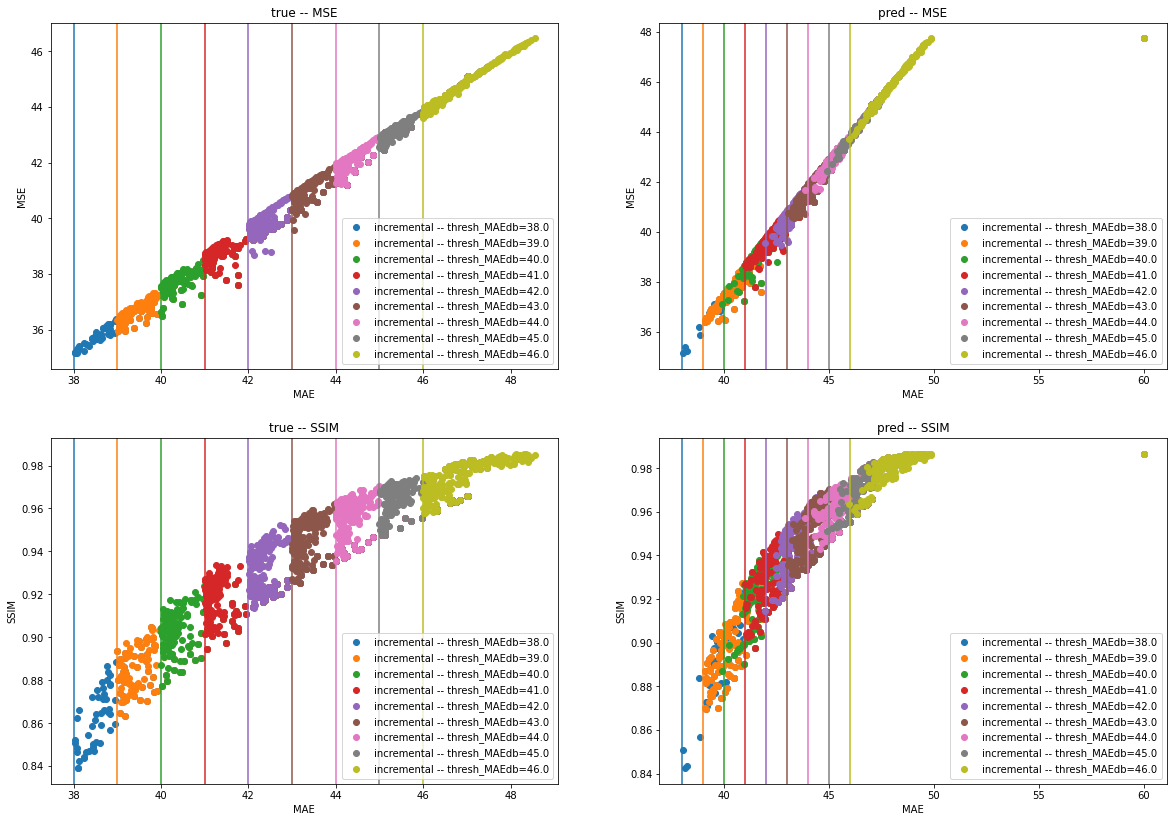

In [56]:
threshold_mae_list = [38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0]
R_tmp = 10.0

vline = True

metric_type_list = ['MSE', 'SSIM']
data_type_list = ['true', 'pred']

fig, axxs = plt.subplots(len(metric_type_list), 2)
fig.set_figwidth(20)
fig.set_figheight(7*len(metric_type_list))

print('\n\n\tcomparison of metric distribution -- classic MRI acquisition VS incremental MRI acquisition\n\n')

plot_list = []
index_list = []

for metric_type, axs in zip(metric_type_list, axxs):
    
    for data_type, ax in zip(data_type_list, axs):
        
        # ax.scatter(tscore_dict['MAE_true'][R_tmp], tscore_dict[metric_type+'_true'][R_tmp], label = f'classic -- R = {R_tmp}', zorder = 100) 
        
        for threshold_mae in threshold_mae_list:
            
            thresh_list_mae = results_based_on_MAEdb_3['thresh_MAE_'+data_type]
            t_mae = thresh_list_mae[np.argmin(np.abs(thresh_list_mae-threshold_mae))]
            mae = results_based_on_MAEdb_3['MAE_'+data_type+'_T'+str(t_mae)+'-show_MAE']
            mse = results_based_on_MAEdb_3['MAE_'+data_type+'_T'+str(t_mae)+'-show_'+metric_type]
            
            if metric_type == 'MSE' and data_type == 'pred':
                mse[mse == 60] = np.max(mse[mse<60])
                
            if metric_type == 'SSIM' and data_type == 'pred':
                mse[mse == 60] = np.max(mse[mse<1])
            
            # speed_up_tmp = results_based_on_MAEdb['speed_up_MAE_'+data_type+'_T'+str(t_mae)]
            # R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)
            
            if threshold_MAEdb == threshold_mae and data_type == 'true':
                [print(f'{metric_type} = {mse[i]} --- MAE > {threshold_mae}, IND = {i}') for i in index_list_tmp]
            
            # scatter = ax.scatter(mae, mse, label = f'incremental -- thresh_MAEdb={threshold_mae} -- R = {np.round(R_incremental, 2)}')
            scatter = ax.scatter(mae, mse, label = f'incremental -- thresh_MAEdb={threshold_mae}')
            
            plot_list += [mse]
            index_list += ['y_'+data_type+'_'+metric_type+'_thresh_'+str(threshold_mae)]
            
            plot_list += [mae]
            index_list += ['x_'+data_type+'_'+metric_type+'_thresh_'+str(threshold_mae)] 
            
            color = scatter.get_facecolors()[0]
            
            ax.axvline(threshold_mae, color = color)
            
            ax.set(title = f'{data_type} -- {metric_type}', xlabel = 'MAE', ylabel = metric_type)
            
            ax.legend();
            
# fig.savefig(os.path.join('results_paper', f'MAE_thr_vs_metric_{use_case}.pdf'),bbox_inches='tight');

f_name = f'metric_vs_MAE-target_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

## Diff with Improved Window Level and colorbar

In [62]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'win_lev',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
        im_tmp = np.abs(im_ref - im_tmp)
        
        # im_tmp = im_tmp / np.max(im_tmp)
    
    
    
    imtmp = ax.imshow(im_tmp, cmap = 'pink', vmax=0.3)
    
    ax.set(xticks = [], yticks = [])
    
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # clbar = fig.colorbar(imtmp, cax=cax, orientation='vertical')
    
    # clbar.set_ticks([np.arange(0,  np.max(im_tmp), , )])
    # clbar.set_ticks(np.arange(0, np.max(im_tmp)))
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

    

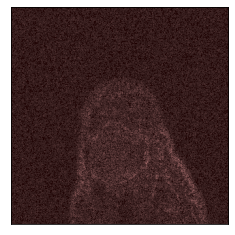

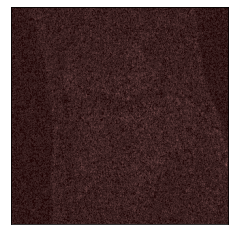

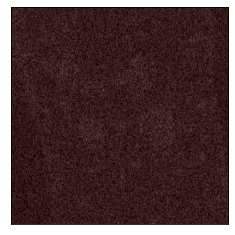

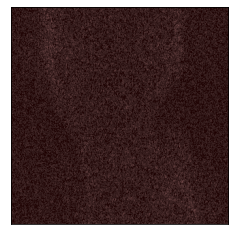

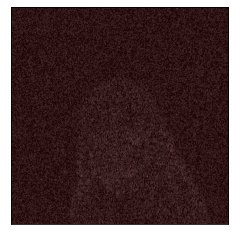

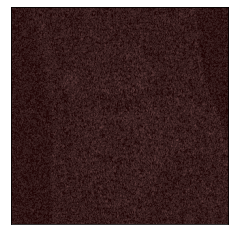

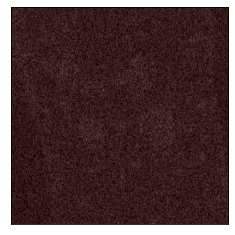

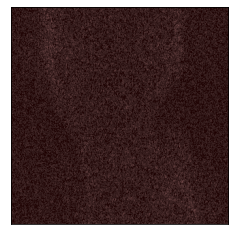

In [69]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'win_lev_simple',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
#         im_ref = im_ref / resc
#         im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
        
    # im_tmp = im_tmp / np.max(im_tmp)
    
    
    
    imtmp = ax.imshow(im_tmp, cmap = 'pink', vmax=0.25)
    
    ax.set(xticks = [], yticks = [])
    
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     clbar = fig.colorbar(imtmp, cax=cax, orientation='vertical')
    
    # clbar.set_ticks([np.arange(0,  np.max(im_tmp), , )])
    # clbar.set_ticks(np.arange(0, np.max(im_tmp)))
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

###################################################################### CLASSIC
    
    
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'win_lev_simple',
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        # im_ref = im_ref / resc
        # im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    # im_tmp = im_tmp / np.max(im_tmp)
    
    imtmp = ax.imshow(im_tmp, cmap = 'pink', vmax=0.25)
    
    ax.set(xticks = [], yticks = [])
    
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(imtmp, cax=cax, orientation='vertical')
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

In [57]:
FINE

NameError: name 'FINE' is not defined

In [ ]:
len(thresh_MAEdb), len(thresh_PSNR), len(thresh_SSIM)

tscore_dict_expanded, R_list_expanded = expand_score_dictand_R_list(tscore_dict, R_list)

In [ ]:
threshold_mae_list = thresh_MAEdb

vline = True

percentile_list = [0, 80, 95]
color_list = ['red', 'blue']

metric_type_list = ['MSE', 'SSIM']
data_type_list = ['true', 'pred']
data_type_list = ['pred']

fig, axxs = plt.subplots(len(metric_type_list), 1)
fig.set_figwidth(20)
fig.set_figheight(7*len(metric_type_list))

print('\n\n\tcomparison of metric distribution -- classic MRI acquisition VS incremental MRI acquisition\n\n')

for metric_type, ax in zip(metric_type_list, axxs):
    
    for data_type, color in zip(data_type_list, color_list):

        metric_percentile = []
        metric_min = []
        
        for threshold_mae in threshold_mae_list:
            
            thresh_list_mae = results_based_on_MAEdb_2['thresh_MAE']
            t_mae = thresh_list_mae[np.argmin(np.abs(thresh_list_mae-threshold_mae))]
            metric = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_mae)+'-show_'+metric_type]
            
            p_tmp = np.percentile(metric, percentile_list)
            
            metric_min += [np.min(metric)]
            metric_percentile += [p_tmp]
            
        # ax.plot(threshold_mae_list, np.array(metric_percentile), color = color, label = data_type)
        
        dash_list = ['-', '--', ':']
        
        [ax.plot(threshold_mae_list, m, d, color = color, label = data_type + ' - ' + str(p)) for m, d, p in zip(np.array(metric_percentile).T, dash_list, percentile_list)]
        
        if metric_type == 'SSIM':
            ylim = (0.6, 1.05)
        elif metric_type == 'MSE' or data_type == 'MAE':
            ylim = (20, 60)
        
    R_adversarial = [
        R_list_expanded[::-1][np.argmax(
            [
                np.sum(tscore_dict_expanded[metric_type+'_true'][R_tmp]>t_tmp)
                for R_tmp in R_list_expanded[::-1]
            ]
        )]
        for t_tmp in metric_min
    ]

    adversarial_percentile = [np.percentile(tscore_dict_expanded[metric_type+'_true'][R_tmp], percentile_list) for R_tmp in R_adversarial]
    
    [ax.plot(threshold_mae_list, m, d, color = 'k', label = 'adversarial' + ' - ' + str(p)) for m, d, p in zip(np.array(adversarial_percentile).T, dash_list, percentile_list)]
    
    # ax.plot(threshold_mae_list, , 'k--', label = 'adversarial')

    ax.set(title = f'{data_type} -- {metric_type} -- {percentile_list}', xlabel = 'threshold MAE', ylabel = metric_type, xlim = (None, None), ylim = (None, None))

    ax.legend();

In [ ]:
FINE

In [18]:
_, _, PD = uty.load_dataset(dataset='PD')
_, _, IXI = uty.load_dataset(dataset = 'IXI')

In [9]:
np.shape(PD)

(186, 320, 320, 1)

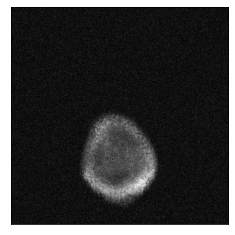

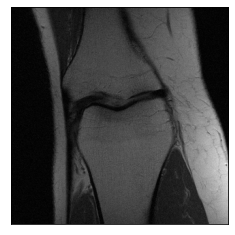

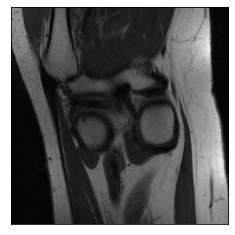

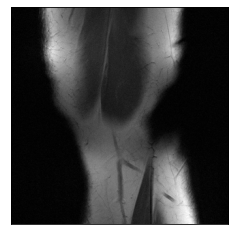

In [38]:
ind_tmp_list = [38, 15, 25, 35]

for ind_tmp in ind_tmp_list:
    
    # plt.imshow(PD[ind_tmp], cmap = 'gray', vmin = 0, vmax = 1)
    plt.imshow(PD[ind_tmp], cmap = 'gray')

    plt.yticks([])
    plt.xticks([])
    
    # plt.savefig(os.path.join('results_paper', f'image_ind_{ind_tmp}_PD.pdf'),bbox_inches='tight', pad_inches = 0)
    
    plt.show()

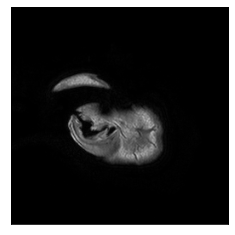

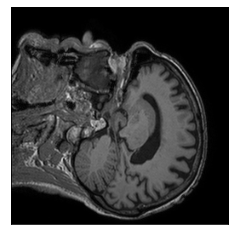

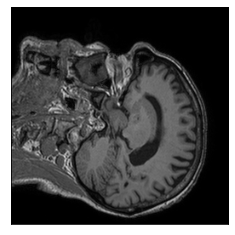

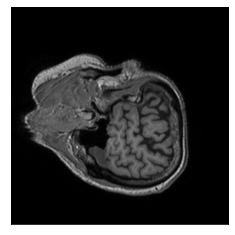

In [32]:
ind_tmp_list = [135, 60, 90, 120]

for ind_tmp in ind_tmp_list:
    
    plt.imshow(IXI[ind_tmp], cmap = 'gray', vmin = 0, vmax = 1)

    plt.yticks([])
    plt.xticks([])
    
    # plt.savefig(os.path.join('results_paper', f'image_ind_{ind_tmp}_IXI.pdf'),bbox_inches='tight', pad_inches = 0)
    
    plt.show()
    

In [ ]:
END

In [ ]:
filt = [10,8,6,4,2,1]
kern = [5]*len(filt)
pool_size = [(2,2)]*len(filt)
average_pooling = True
poly_degree = 2
dense = False
conv_per_block_image = 1
units = [100, 20]
from modules import models
model_self_assessment = models.model_self_assessment(
        input_shape_image = (256, 256, 1),
        input_shape_metric = (1,),
        line_coeff = [0, 1],
        filt = filt,
        kern = kern,
        pool_size = pool_size,
        average_pooling = average_pooling,
        poly_degree = poly_degree,
        dense = dense,
        conv_per_block_image = conv_per_block_image,
        name = 'model_self_assessment_version'+str(0),
    )

In [42]:
model_self_assessment.summary()

Model: "model_self_assessment_version0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 256, 256, 40  1040        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 relu_0 (LeakyReLU)             (None, 256, 256, 40  0           ['conv_0[0][0]']                 
                                )                                    

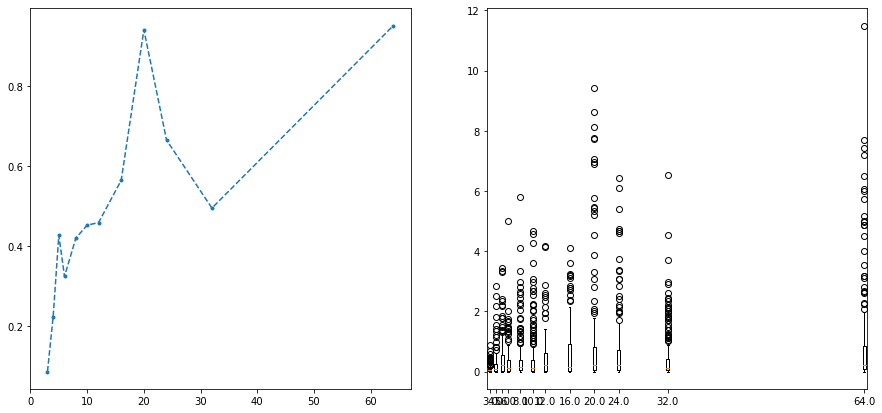

In [67]:
q_true = tscore_dict['MAE_true']
q_pred = tscore_dict['MAE_pred']

plot = []
box = np.empty((len(q_true.keys()), len(list(q_true.values())[0])))

for i, (kt, vt, kp, vp) in enumerate(zip(q_true.keys(), q_true.values(), q_pred.keys(), q_pred.values())):
    plot += [np.mean((vt-vp)**2)]
    box[i] = (vt-vp)**2
    
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(list(q_true.keys())[:-1], plot[:-1], '.--')
ax[1].boxplot(box[:-1].T, positions=list(q_true.keys())[:-1]);

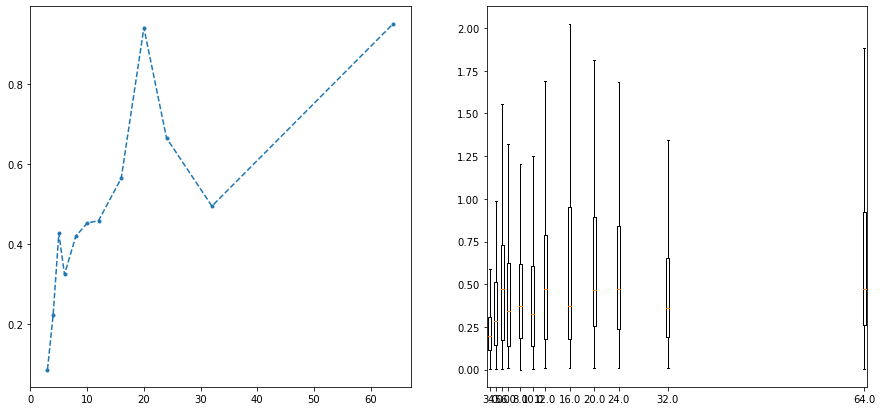

In [81]:
q_true = tscore_dict['MAE_true']
q_pred = tscore_dict['MAE_pred']

plot = []
box = np.empty((len(q_true.keys()), len(list(q_true.values())[0])))

for i, (kt, vt, kp, vp) in enumerate(zip(q_true.keys(), q_true.values(), q_pred.keys(), q_pred.values())):
    plot += [np.mean((vt-vp)**2)]
    # box[i] = (vt-vp)**2
    # box[i] = np.abs(vt-vp)
    box[i] = np.abs(vt - vp)
    
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(list(q_true.keys())[:-1], plot[:-1], '.--')
ax[1].boxplot(box[:-1].T, positions=list(q_true.keys())[:-1], sym='');

In [82]:
with open(os.path.join('csv', 'box', f'boxplot-{use_case}.pkl'), 'wb') as f:
    dict_save = {
        'x': list(q_true.keys())[:-1],
        'y': box[:-1]}
    pkl.dump(dict_save, f)

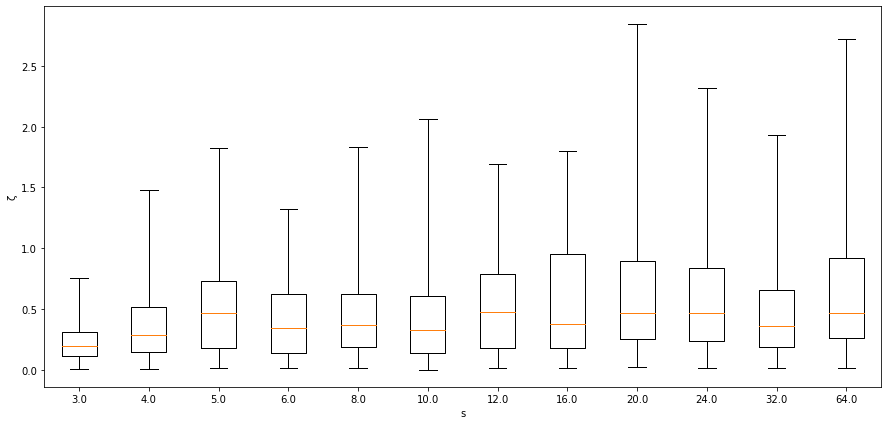

In [84]:

fig, ax = plt.subplots(figsize=(15, 7))
ax.boxplot(box[:-1].T, sym='', positions=None, whis=(1, 99), labels=list(q_true.keys())[:-1]);
ax.set(xlabel='s', ylabel='ζ')
fig.savefig(os.path.join('results_paper', f'box-{use_case}.pdf'))